In [1]:
import __init__ as init
import os
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import seaborn as sns

import xlrd
import numpy as np
import networkx as nx
import pandas as pd

In [2]:


allConcepts = []
for root, dirs, files in os.walk("./data", topdown=False):
    for name in files:
        if "allFCMs" not in name and name != ".DS_Store":
            fileLocation = os.path.join(root, name)
            df = pd.read_excel(fileLocation)
            df.head()
            concepts = np.delete(df.columns.values, 0)
            if 'System maintainance' in concepts:
                print(name, True)
            allConcepts.append(list(concepts))
            

In [3]:
conceptTable = []
id = 0
for model in allConcepts:
    for concept in model:
        conceptTable.append([id, concept])
    id+=1
df_concepts = pd.DataFrame(data=conceptTable, columns=["model_id","concept"]) 
print(df_concepts.count())
df_concepts.head(5)

model_id    278
concept     278
dtype: int64


model_id                  concept
0         0                 rainfall
1         0      impervious surfaces
2         0          riparian buffer
3         0  land conservation areas
4         0                 flooding

153


Text(0.5, 1.0, 'All Model Variables')

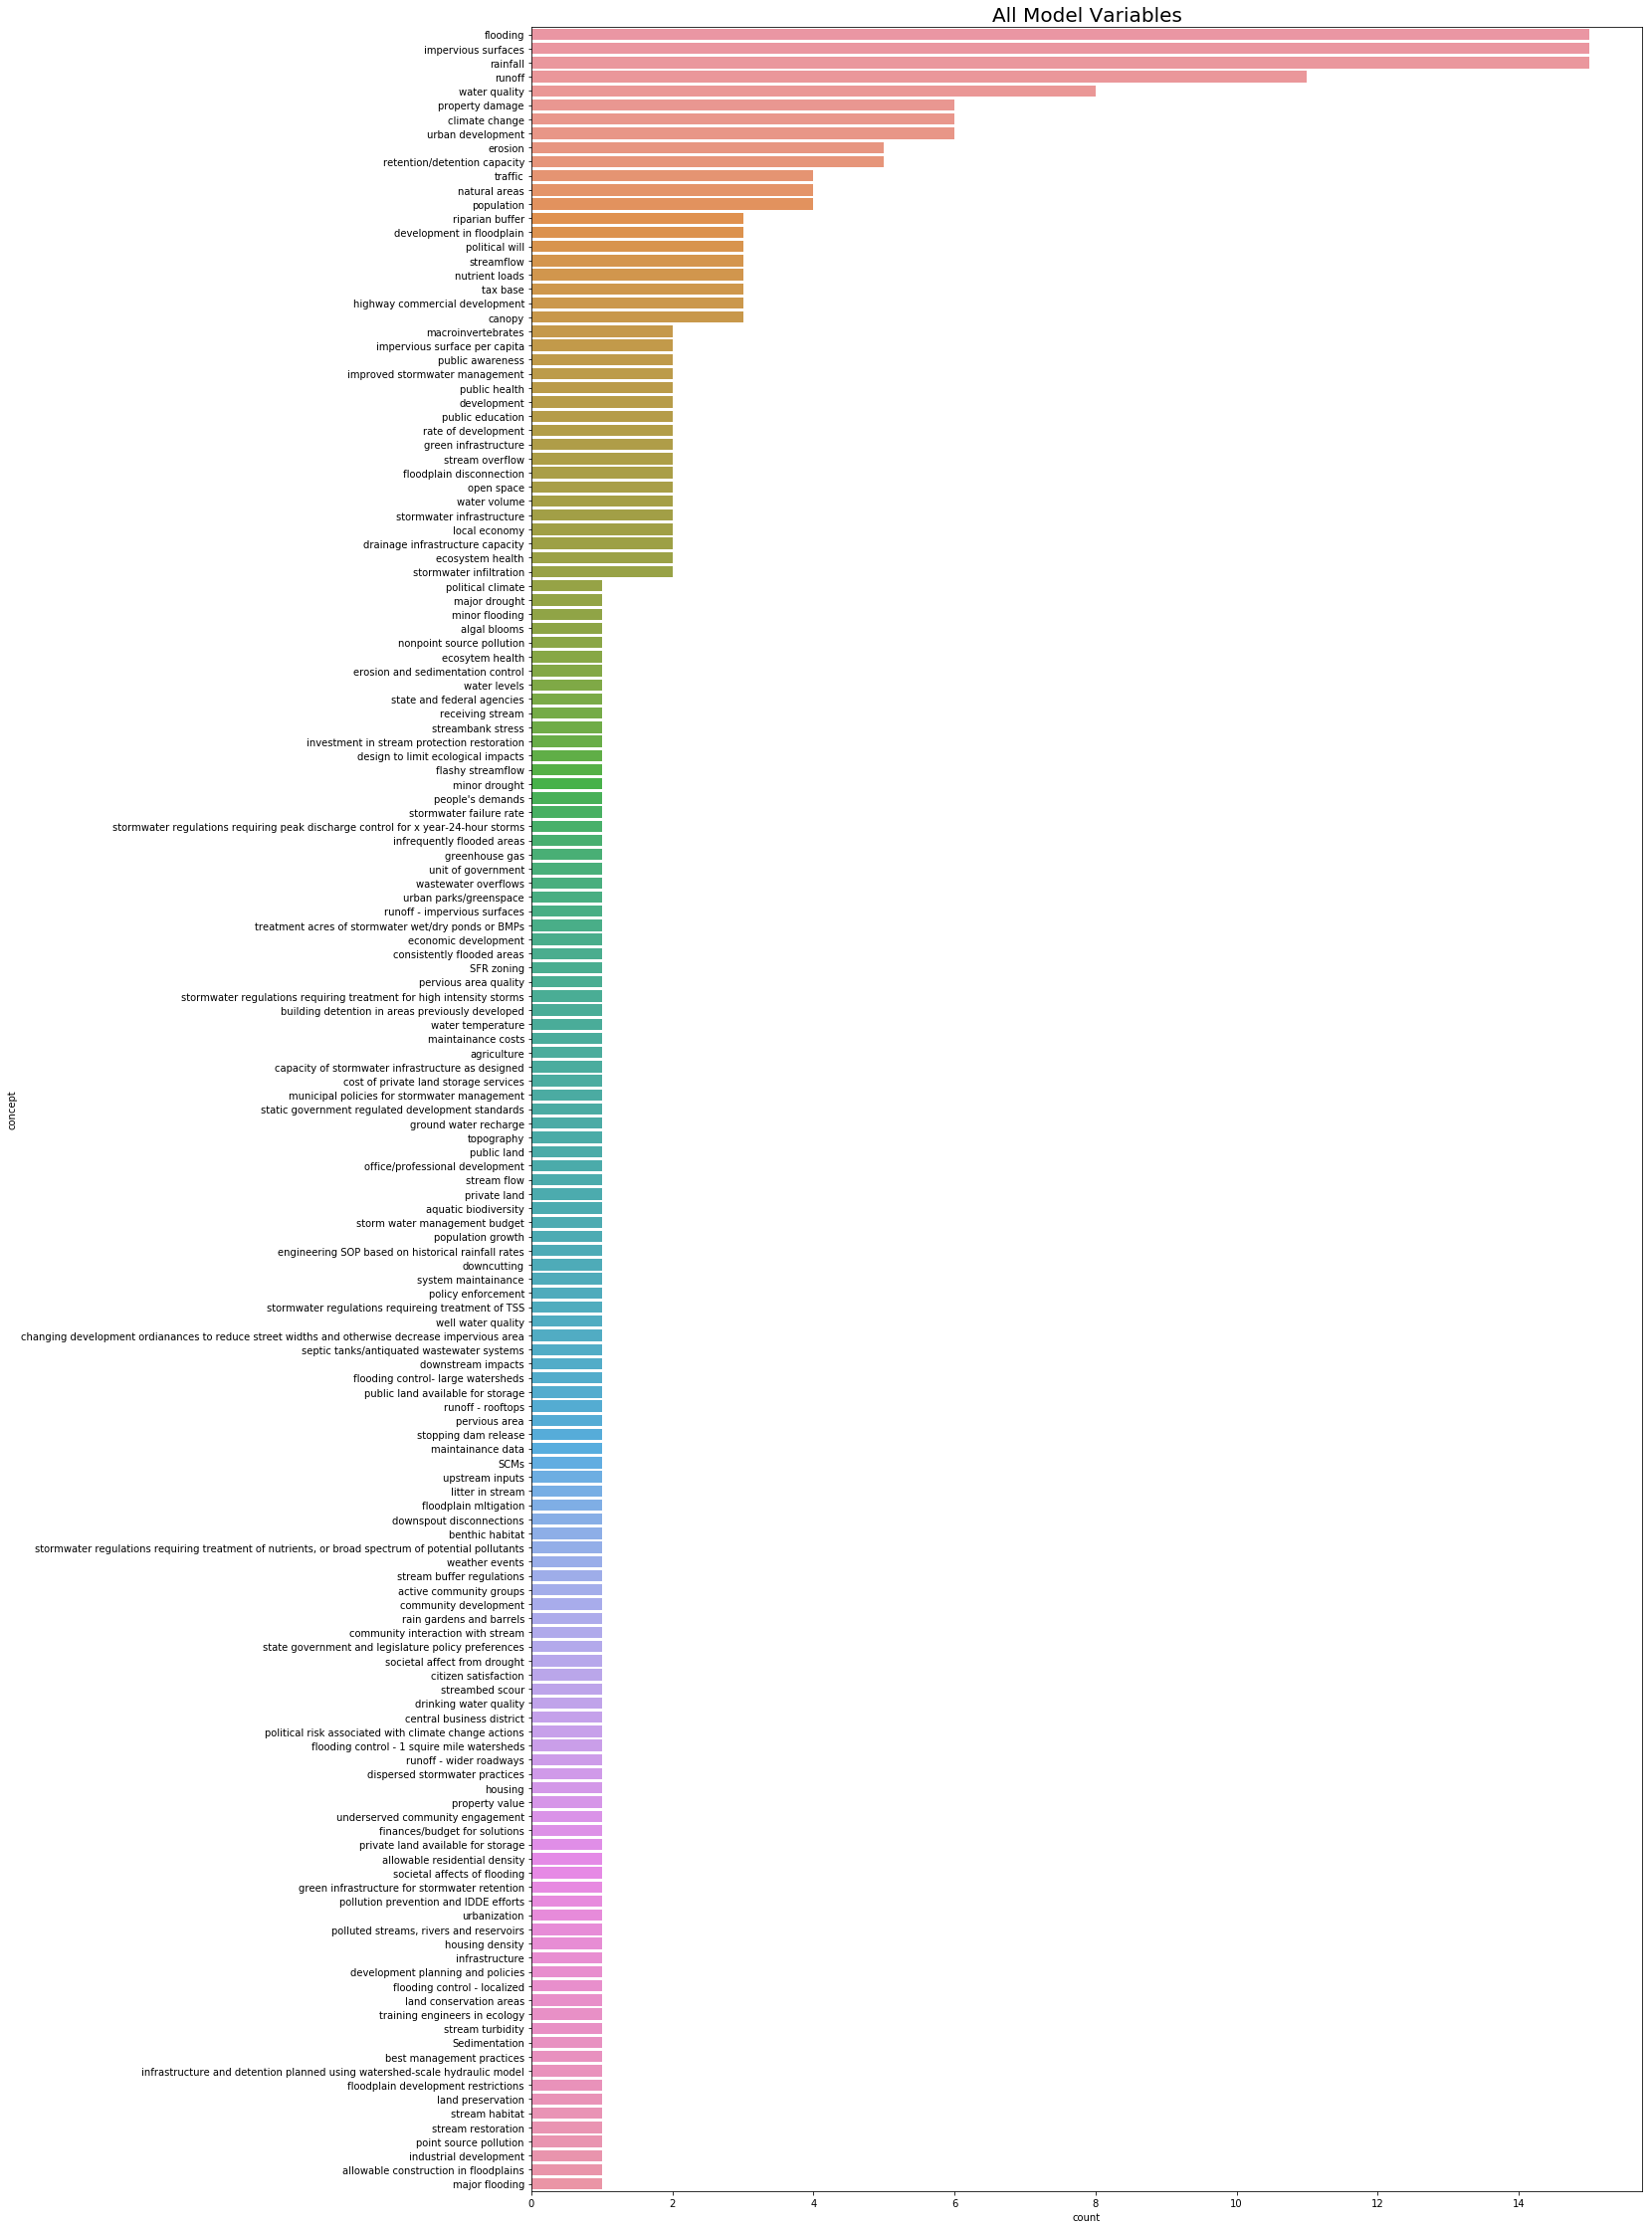

In [4]:
print(len(df_concepts['concept'].unique()))
fig,ax= plt.subplots(figsize=(20, 40))

sns.countplot(y="concept", data=df_concepts,ax=ax, order = df_concepts['concept'].value_counts().index)
ax.set_title(("All Model Variables"), fontsize=20)

# sns.countplot(y="concept", col_wrap=5, data=df_concepts, kind="count",height=4, aspect=.7)

The mean number of variables in each participants FCM is 13 and follows a normal distribution.

         concept
count  21.000000
mean   13.238095
std     3.548306
min     7.000000
25%    11.000000
50%    13.000000
75%    16.000000
max    20.000000


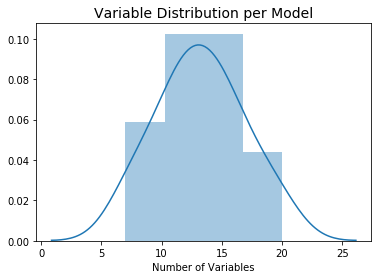

In [5]:
df_model_counts = df_concepts.groupby('model_id').count()
# print(df_model_counts.head())
print(df_model_counts.describe())
# df_model_counts.avg()
fig, ax = plt.subplots()
ax.set_title(("Variable Distribution per Model"), fontsize=14)
ax.set_xlabel("Number of Variables")
sns.distplot(df_model_counts, ax=ax)

In [6]:
df_concepts.head(20)

model_id                         concept
0          0                        rainfall
1          0             impervious surfaces
2          0                 riparian buffer
3          0         land conservation areas
4          0                        flooding
5          0  dispersed stormwater practices
6          0                  nutrient loads
7          0               population growth
8          0               urban development
9          0                   water quality
10         0                          runoff
11         0                 property damage
12         1                        flooding
13         1                        rainfall
14         1           ground water recharge
15         1             impervious surfaces
16         1                          canopy
17         1        floodplain disconnection
18         1                   water quality
19         1                          runoff

An accumlation curve was generated using Monte Carlo techniques to generate 500 possible accumulations of variables to determine if the sample size of maps is large enough to capture the complexity of the model (Özesmi and Özesmi, 2004). The accumulation curve of total variables (Figure 1) shows that the number of new variables added by each map has not yet reached a stable state, and the accumulation curve of new variable shows that the number of new variable captured with each new map is decreasing, but that stakeholders do not share a strong shared vocabulary.

In [7]:
from sklearn.utils import shuffle
from matplotlib.ticker import MaxNLocator

def fcm_accumualtion_curve(df,ax=None, new_variables=False, n=500):
    """Generate accumulation curve of the number of model variables by using
    a Monte Carlo technique to determine how the variables accumulate.
    
    :param df: DataFrame.
    :param ax: axes object from matplotlib.
    :param new_variables: Deterimes which accumulation curve to generate. False generates the total varibale accumulation curve and True generates the new variables accumulation curve.
    :param n: Number of time to run Monte Carlo simulation.
    :return: ax and plt
    """
    ax = ax or plt.gca()
    
    #Set random seed for shuffling dataframes
    np.random.seed(1)
    
    #DataFrame to store the results of each accumualtion curve
    allDataFrames = pd.DataFrame()
    

    df_models = df.groupby('model_id')['concept'].apply(list).reset_index()
    
    for x in range(n+1):
        #empty set that is used to keep track of which concepts are already counted. It is reset to empty during each iteration
        used_concepts = set()

        def _accumulate(concepts):
            """Determines new concepts and adds them to used_concepts set to keep track
            
            :param concepts: List of model concepts (variables).
            :return: Count of new concepts add from each model.
            """
            new_concepts = 0
            for concept in concepts:
                if concept not in used_concepts:
                    used_concepts.add(concept)
                    new_concepts+=1
            return new_concepts
        
        df_shuffled = shuffle(df_models)
        df_accumulate = df_shuffled['concept'].apply(_accumulate)
        if new_variables:
            df_concept_cum_sum = df_accumulate.reset_index()
        else:
            df_concept_cum_sum = df_accumulate.cumsum(0).reset_index()
            
        #Concat all accumulation curves into a single dataframe to generate the average, min, and max.
        allDataFrames = pd.concat((allDataFrames, df_concept_cum_sum))
    
   
    
    df_mean = allDataFrames.groupby(level=0).mean()
    df_mean['name'] = "Mean"
    df_mean['index_col'] = df_mean.index
    
#     df_min=allDataFrames.groupby(level=0).min()
#     df_min['name'] = "Envelope"
#     df_min['index_col'] = df_min.index
    
#     df_max = allDataFrames.groupby(level=0).max()
#     df_max['name'] = "Envelope"
#     df_max['index_col'] = df_max.index

    
#     df_final = pd.concat([df_mean, df_min, df_max])
    
    #Plot the mean and the envelope
    palette = sns.color_palette("mako_r", 1)
    sns.lineplot(
        x="index_col",
        y="concept",
        hue="name",
        style="name",
        markers=True,
        dashes=True, 
        data=df_mean,
        palette=palette,
        legend="brief",
        ax=ax)
    
    #Configure plot labels
    plt.suptitle('Accumulation Curves', fontsize=14)
    ax.set_xlabel("Number of Maps")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    if new_variables:
        ax.set_title(("Number of New Variables (n=%d)" % n ), fontsize=10)
        ax.set_ylabel("Number of New Variables")
    else:
        ax.set_title(("Number of Variables (n=%d)" % n ), fontsize=10)
        ax.set_ylabel("Number of Variables") 
        
    return ax, plt


(<matplotlib.axes._subplots.AxesSubplot at 0x10c961128>,
 <module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>)

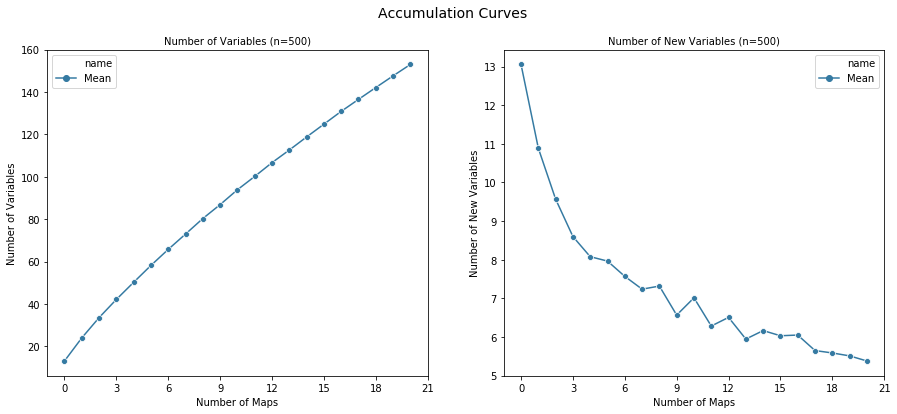

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6))
fcm_accumualtion_curve(df_concepts,ax1,new_variables=False, n= 500)   
fcm_accumualtion_curve(df_concepts,ax2,new_variables=True, n= 500)   

In [9]:
def graph_complexity(r,t):
    """Calculates grapth complexity by returning the ratio of receivers to transmitters. Complex maps have a higher ratio
    define more outcomes and have less forces that contorl the system.
    
    :param r: Receiver.
    :param t: Transmitter.
    :return: Graph complexity as a float.
    """
    complexity = float('NaN')
    try:
        complexity = float(r)/float(t)
    except ZeroDivisionError:
        print("Complexity can not be calculated because the graph has zero transmitters")
    return complexity

        
        
    

In [10]:
def generate_map(data, columns, ax=None):
    """Generates FMC graph and basic statistics
    
    :param data: np.matrix of graph values
    :param columns: List of column names used to label graph nodes.
    :param ax: Axes object from matplotlib.
    
    :return: Dictionary of graph statistics.
    """
    ax = ax or plt.gca()
    G = nx.DiGraph(data)
    
    transmitters = 0
    receivers = 0
    ordinary = 0

    for out_node, out_degree in G.out_degree():
        for in_node, in_degree in G.in_degree():
            if (in_node == out_node):
                #Receiver Varibale
                if (in_degree > 0 and out_degree == 0):
                    receivers+=1
#                     print("Node %d is a receiver variable" % in_node)
                #Transmitter Varibale
                elif (out_degree > 0 and in_degree == 0):
                    transmitters+=1
#                     print("Node %d is a transmitter variable" % in_node)
                else:
                    ordinary+=1

    everylarge=[(u,v) for (u,v,d) in G.edges(data=True) if abs(d['weight']) >=0.75]
    elarge=[(u,v) for (u,v,d) in G.edges(data=True) if abs(d['weight']) >0.5 and abs(d['weight']) <0.75]
    esmall=[(u,v) for (u,v,d) in G.edges(data=True) if abs(d['weight']) <=0.5 and abs(d['weight']) >0.25]
    everysmall=[(u,v) for (u,v,d) in G.edges(data=True) if abs(d['weight']) <=0.25]
    
#     poseverylarge=[(u,v) for (u,v,d) in G.edges(data=True) if abs(d['weight']) >=0.75]
#     poselarge=[(u,v) for (u,v,d) in G.edges(data=True) if abs(d['weight']) >0.5 and abs(d['weight']) <0.75]
#     posesmall=[(u,v) for (u,v,d) in G.edges(data=True) if abs(d['weight']) <=0.5 and abs(d['weight']) >0.25]
#     poseverysmall=[(u,v) for (u,v,d) in G.edges(data=True) if abs(d['weight']) <=0.25]
    
#     negeverylarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >=-0.75]
#     negelarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >-0.5 and d['weight'] <-0.75]
#     negesmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=-0.5 and d['weight'] >-0.25]
#     negeverysmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=-0.25]

    #################Centrality#####################################################################
    label= {}
    for nod in G.nodes():
        label[nod] = columns[nod]

    # pos = nx.random_layout(G, dim=2)
    pos=nx.spring_layout(G,dim=2, k=0.75)
    #########################Visualization##############################################################
    nx.draw_networkx(G,pos,labels=label,font_size=12, node_size= 200 ,node_color='lightgreen' ,alpha=0.6)
    nx.draw_networkx_edges(G,pos,edgelist=everylarge, width=2,alpha=0.5,edge_color='gold')
    nx.draw_networkx_edges(G,pos,edgelist=elarge, width=1.5,alpha=0.5,edge_color='g',style='dashed')
    nx.draw_networkx_edges(G,pos,edgelist=esmall, width=1,alpha=0.5,edge_color='lightcoral',style='dashed')
    nx.draw_networkx_edges(G,pos,edgelist=everysmall, width=0.25,alpha=0.5,edge_color='lightgray',style='dashed')
#     nx.write_edgelist(G, "aggregated_edg.csv")
    print(pd.DataFrame(np.sum(data, axis = 0) + np.sum(data, axis=1), columns=["centrality"], index=columns).sort_values(by=['centrality'], ascending=False).head(25))

    map_stats = {
        "ordinary": ordinary,
        "receivers": receivers,
        "transmitters":transmitters,
        "total variables": transmitters + receivers + ordinary
    }
    
    map_stats["density"] = nx.density(G)
    if transmitters != 0:
        map_stats["complexity"] = graph_complexity(receivers, transmitters)
        map_stats["hierarchy"] = nx.flow_hierarchy(G)
    else:
        print("Zero transmitters identified")
        
    return map_stats


                                centrality
impervious surfaces                   1.55
runoff                                1.55
flooding                              1.52
riparian buffer                       1.51
nutrient loads                        0.51
property damage                       0.51
rainfall                              0.50
population growth                     0.50
water quality                        -0.50
land conservation areas              -1.00
urban development                    -1.00
dispersed stormwater practices       -1.53
                          centrality
rainfall                        1.44
floodplain disconnection        1.25
stream flow                     1.10
ground water recharge           0.90
impervious surfaces             0.81
water temperature               0.21
flooding                        0.15
runoff                         -0.03
erosion                        -0.08
canopy                         -0.51
macroinvertebrates             -0.

                               centrality
streambank stress                    1.62
streamflow                           1.44
water volume                         1.11
erosion                              0.80
flooding                             0.76
pervious area quality                0.54
impervious surfaces                  0.28
stormwater infiltration              0.28
pervious area                        0.02
retention/detention capacity        -0.39
SFR zoning                          -0.78
impervious surface per capita       -0.85
housing density                     -1.63
                                                    centrality
flooding control - localized                              3.60
flooding control - 1 squire mile watersheds               2.69
water quality                                             2.57
stream buffer regulations                                 2.15
infrastructure and detention planned using wate...        1.77
building detention in areas previo

/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


                     centrality
impervious surfaces        0.46
urbanization               0.37
property damage            0.07
property value            -0.03
canopy                    -0.11
riparian buffer           -0.22
traffic                   -0.28
water quality             -0.54
flooding                  -0.91
natural areas             -0.94
public health             -1.43


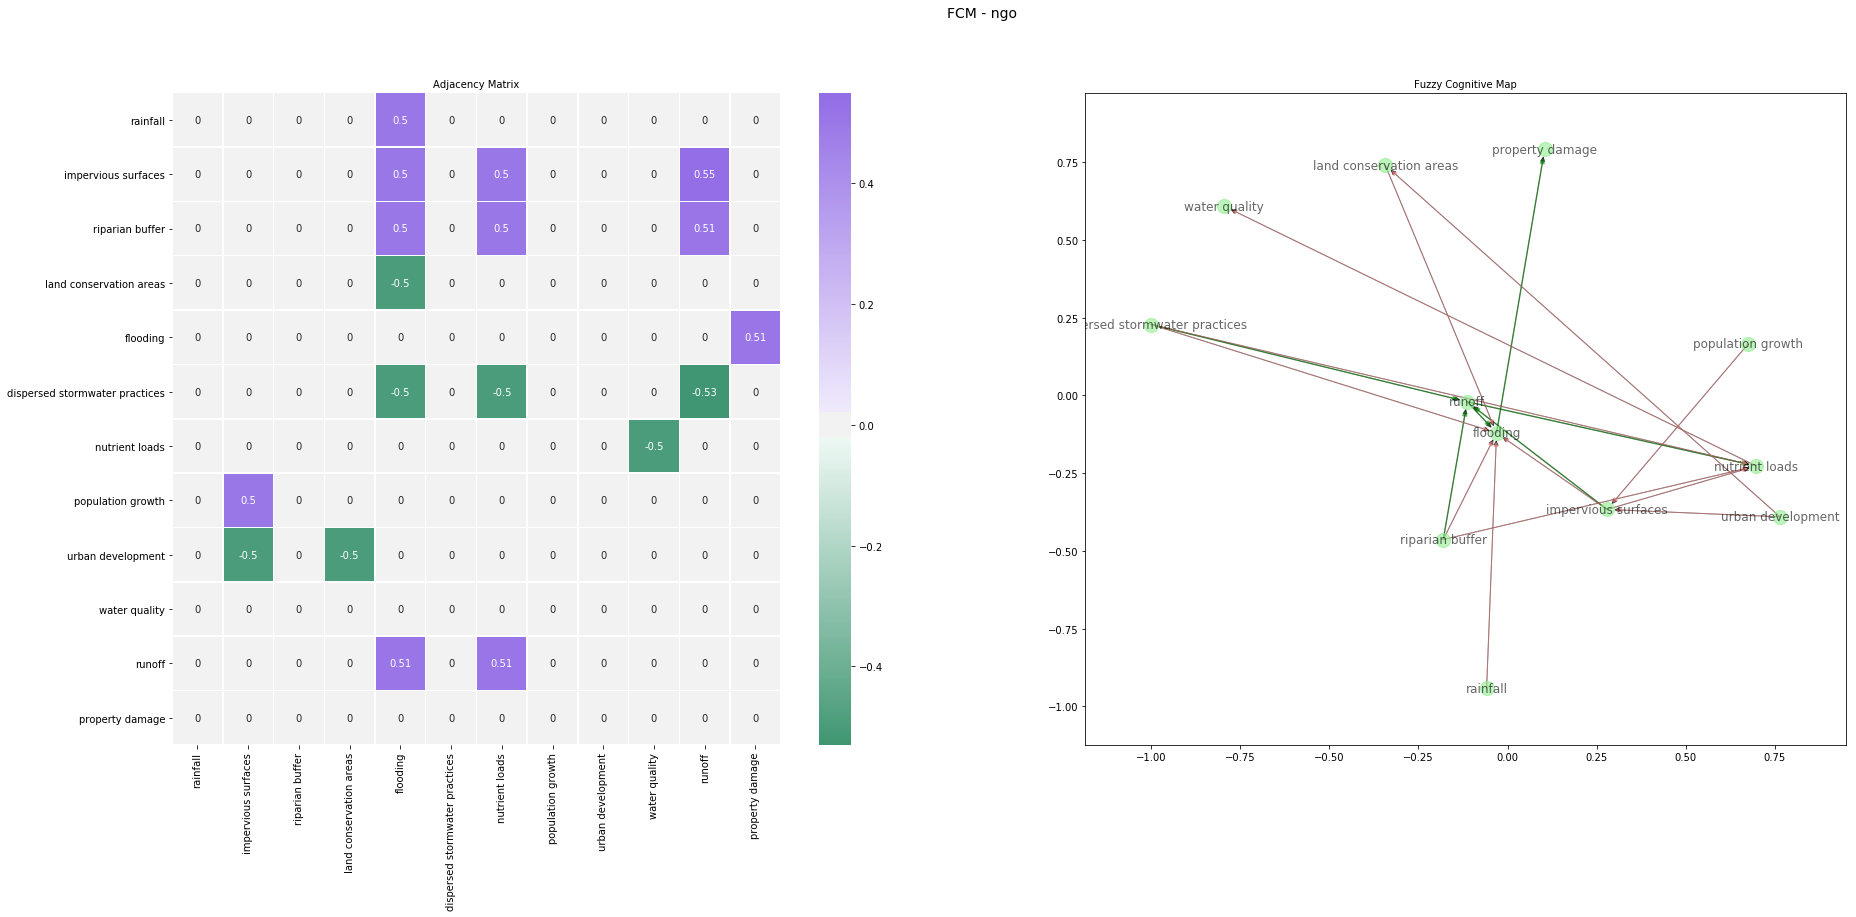

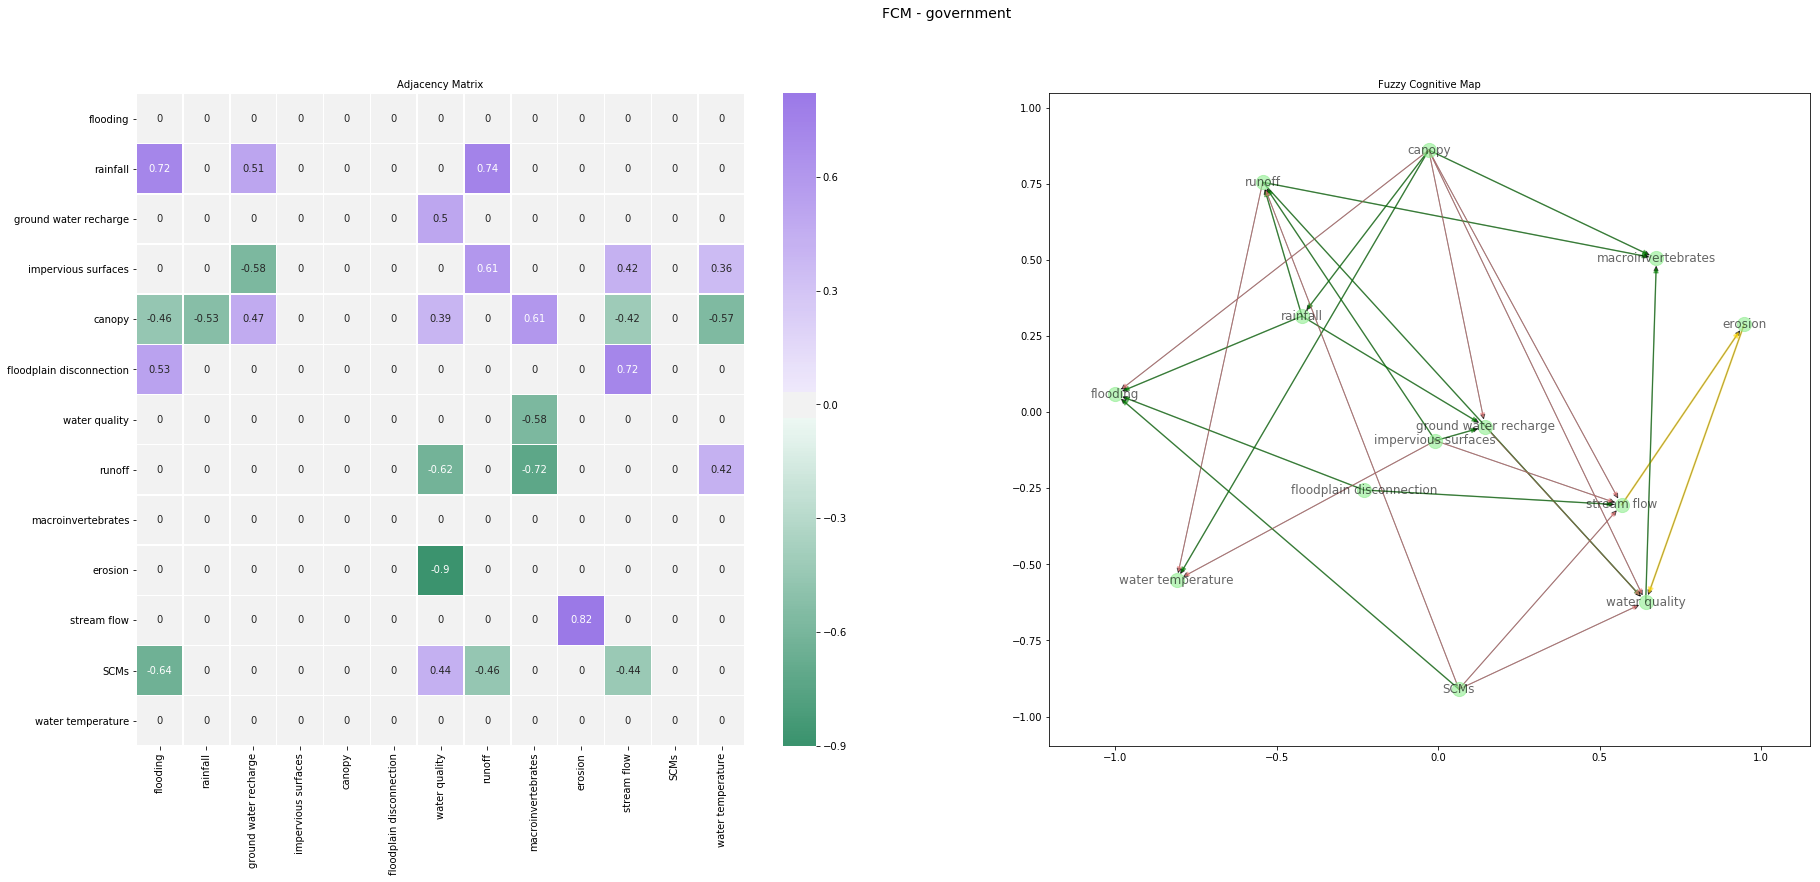

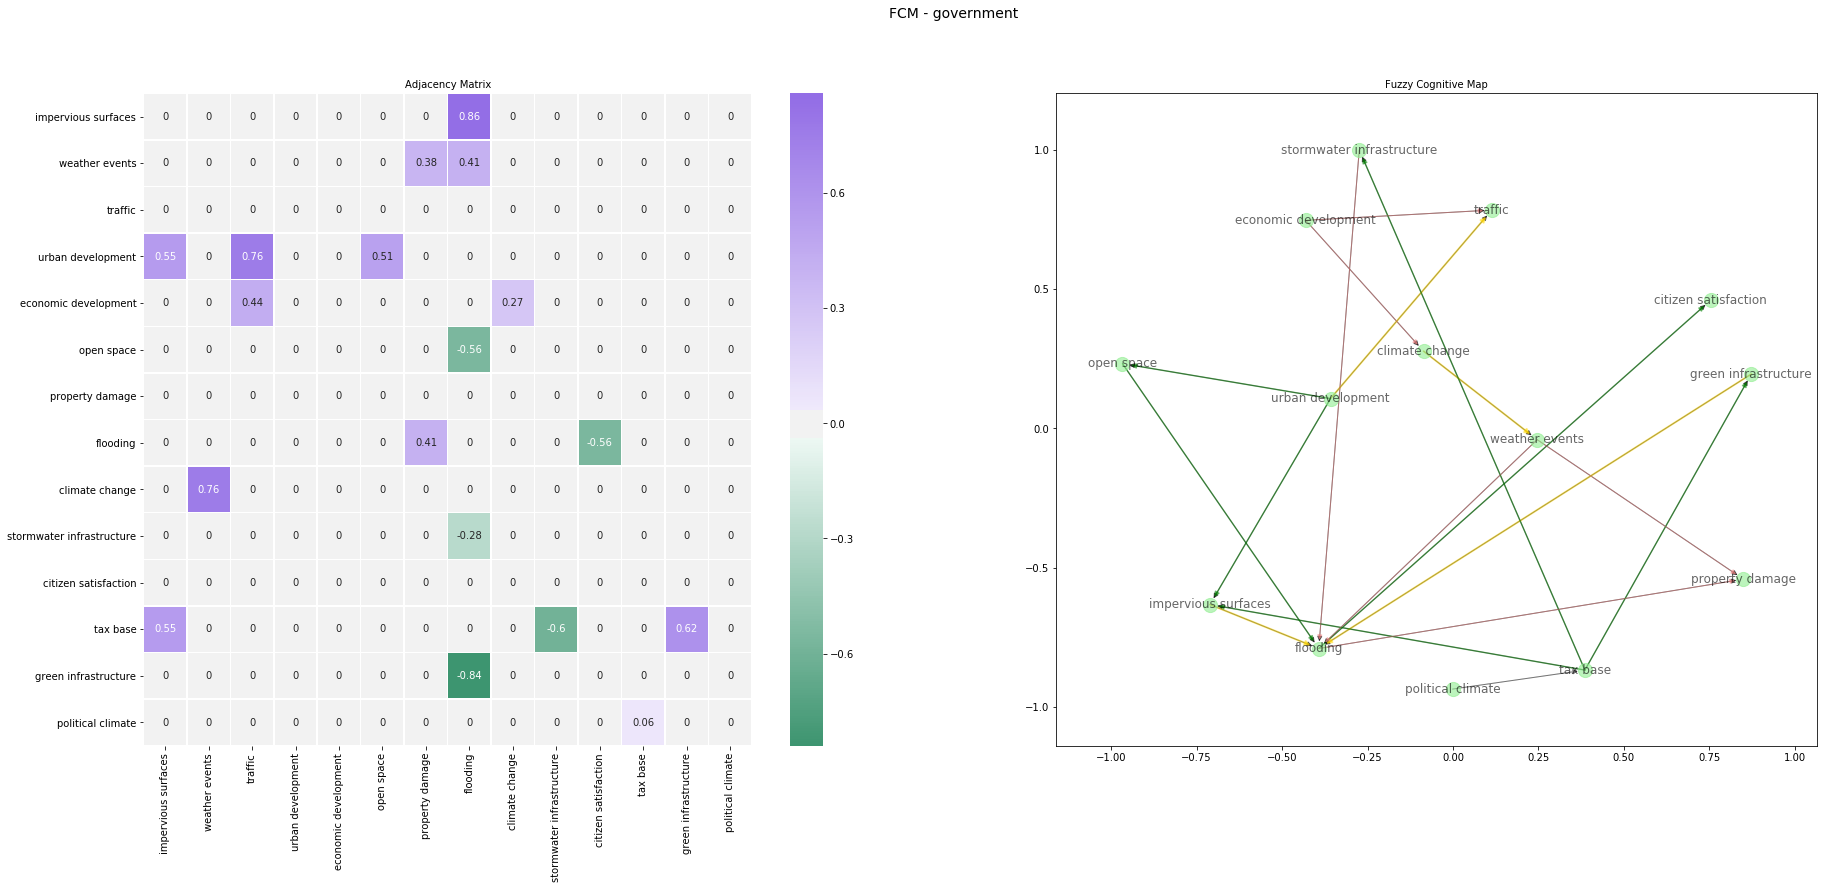

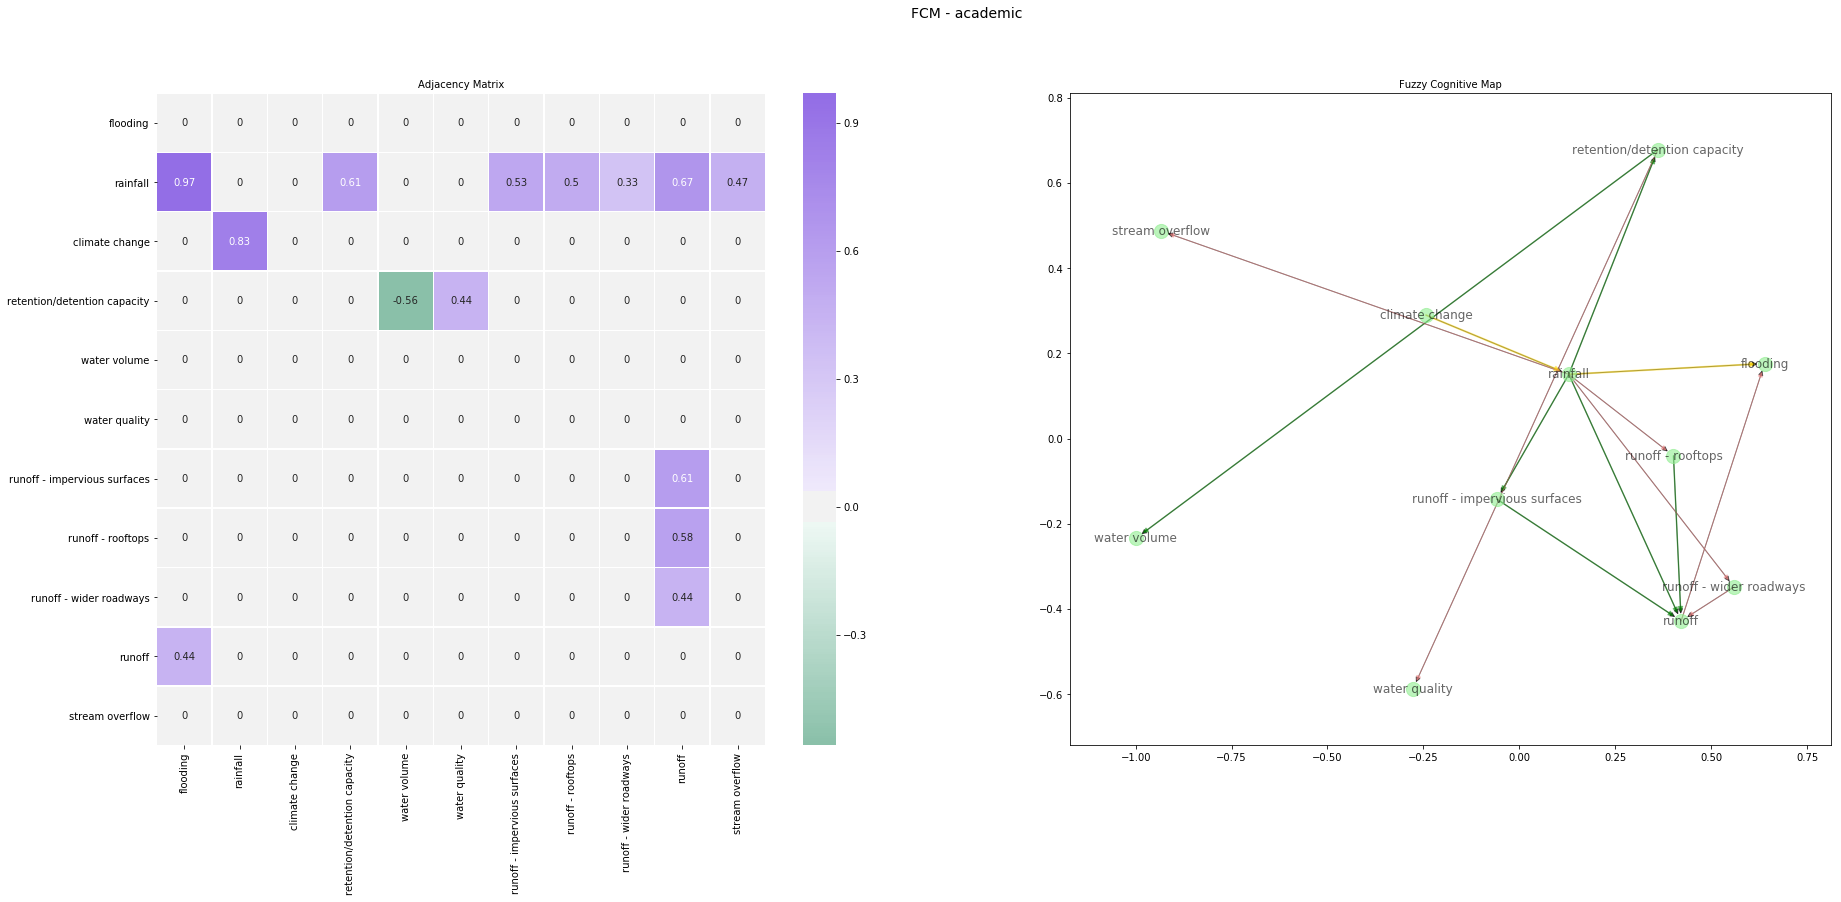

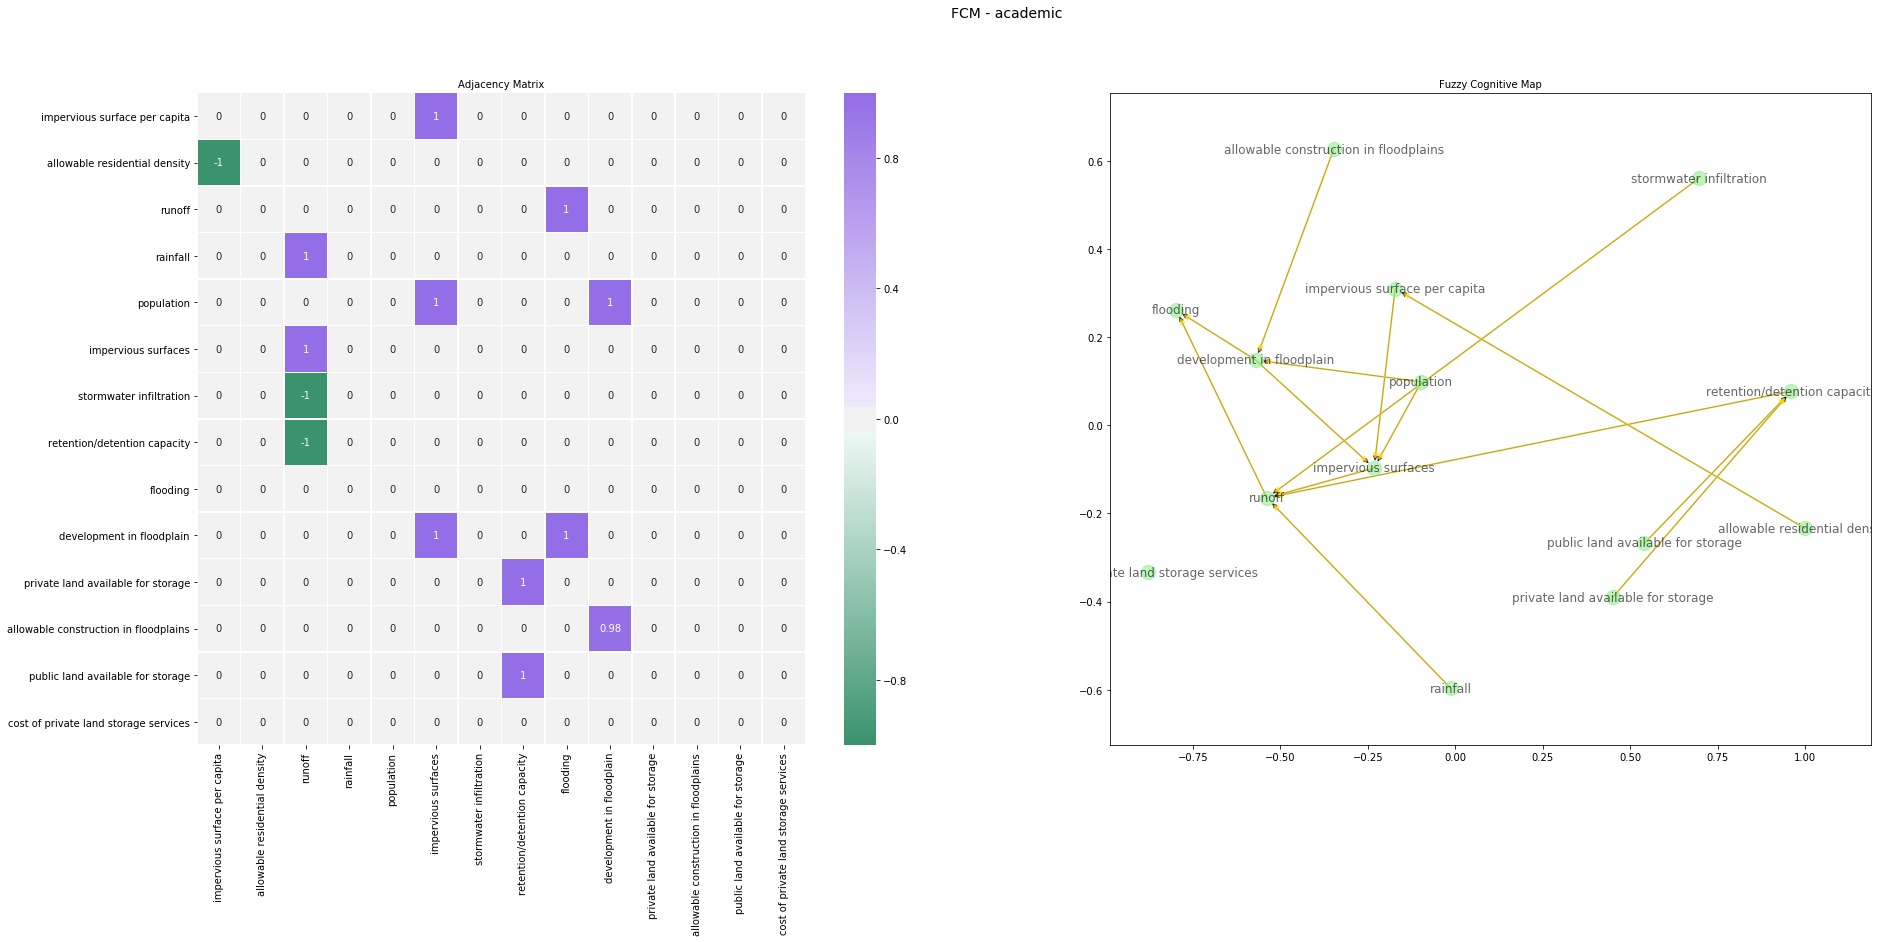

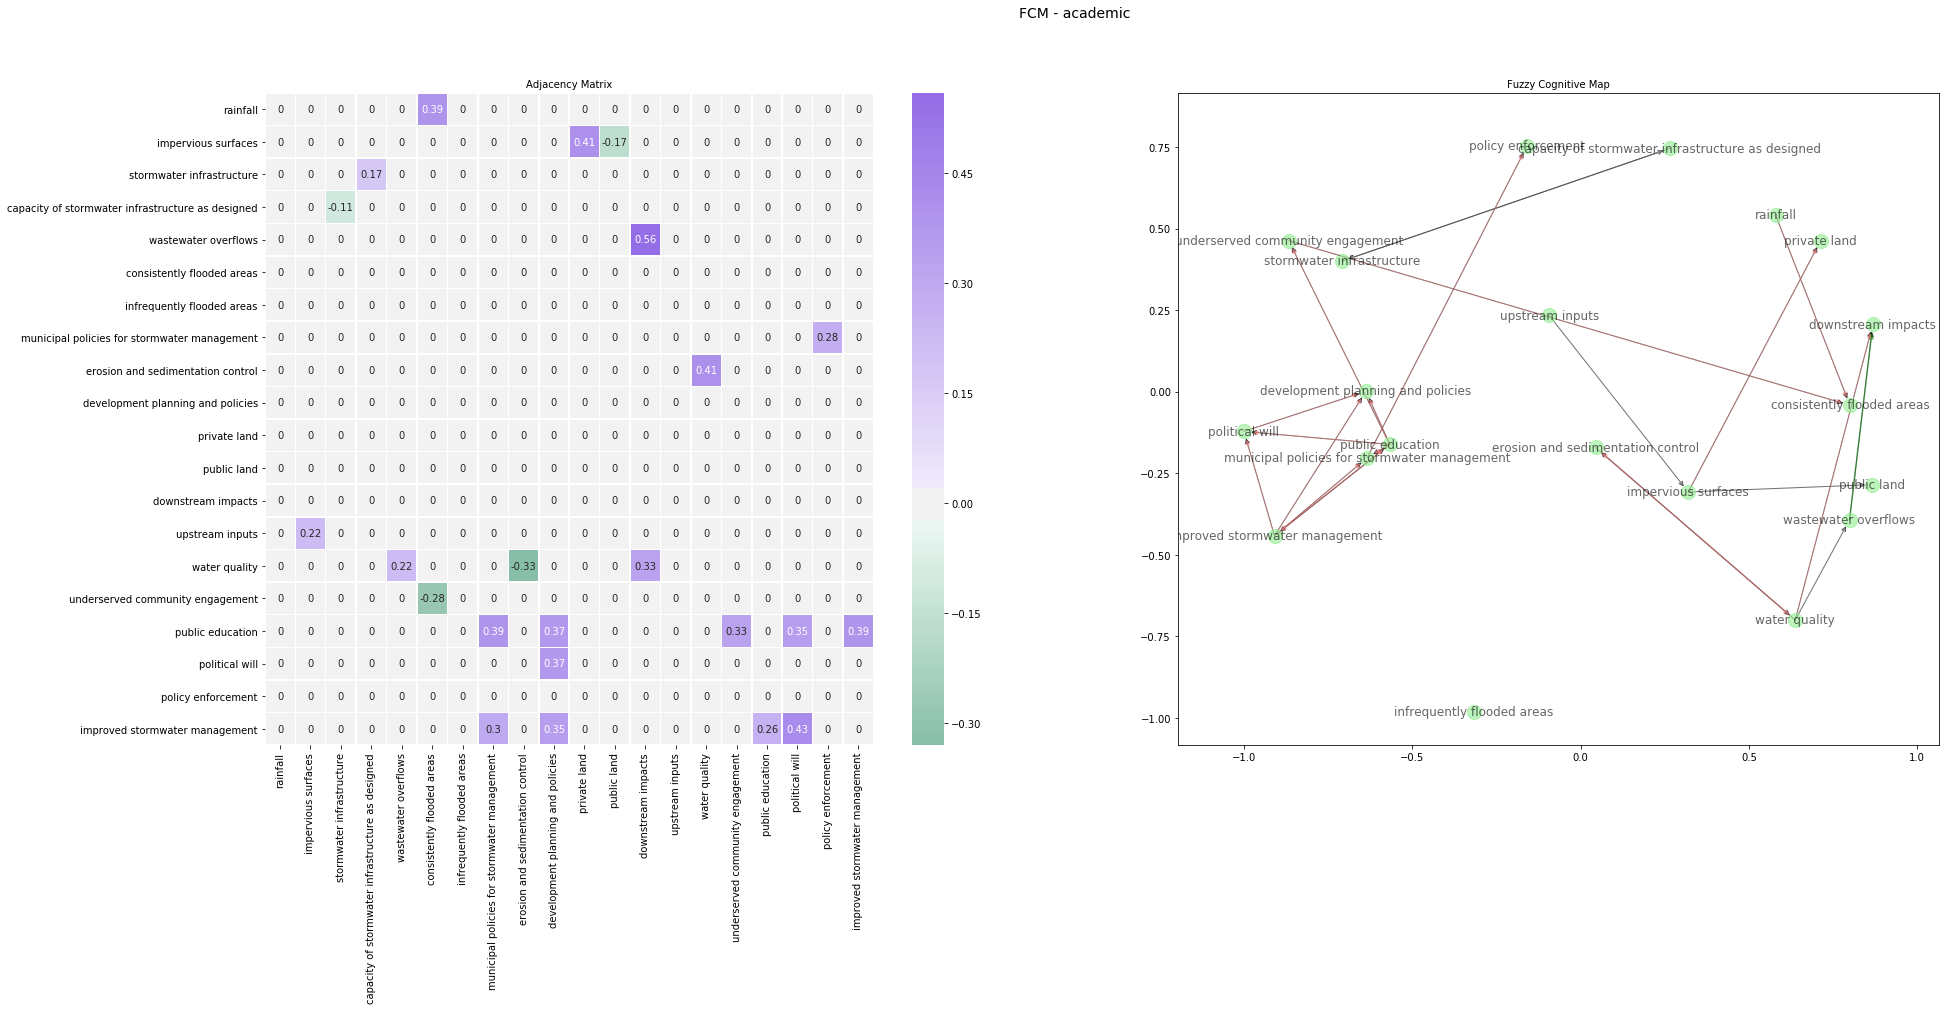

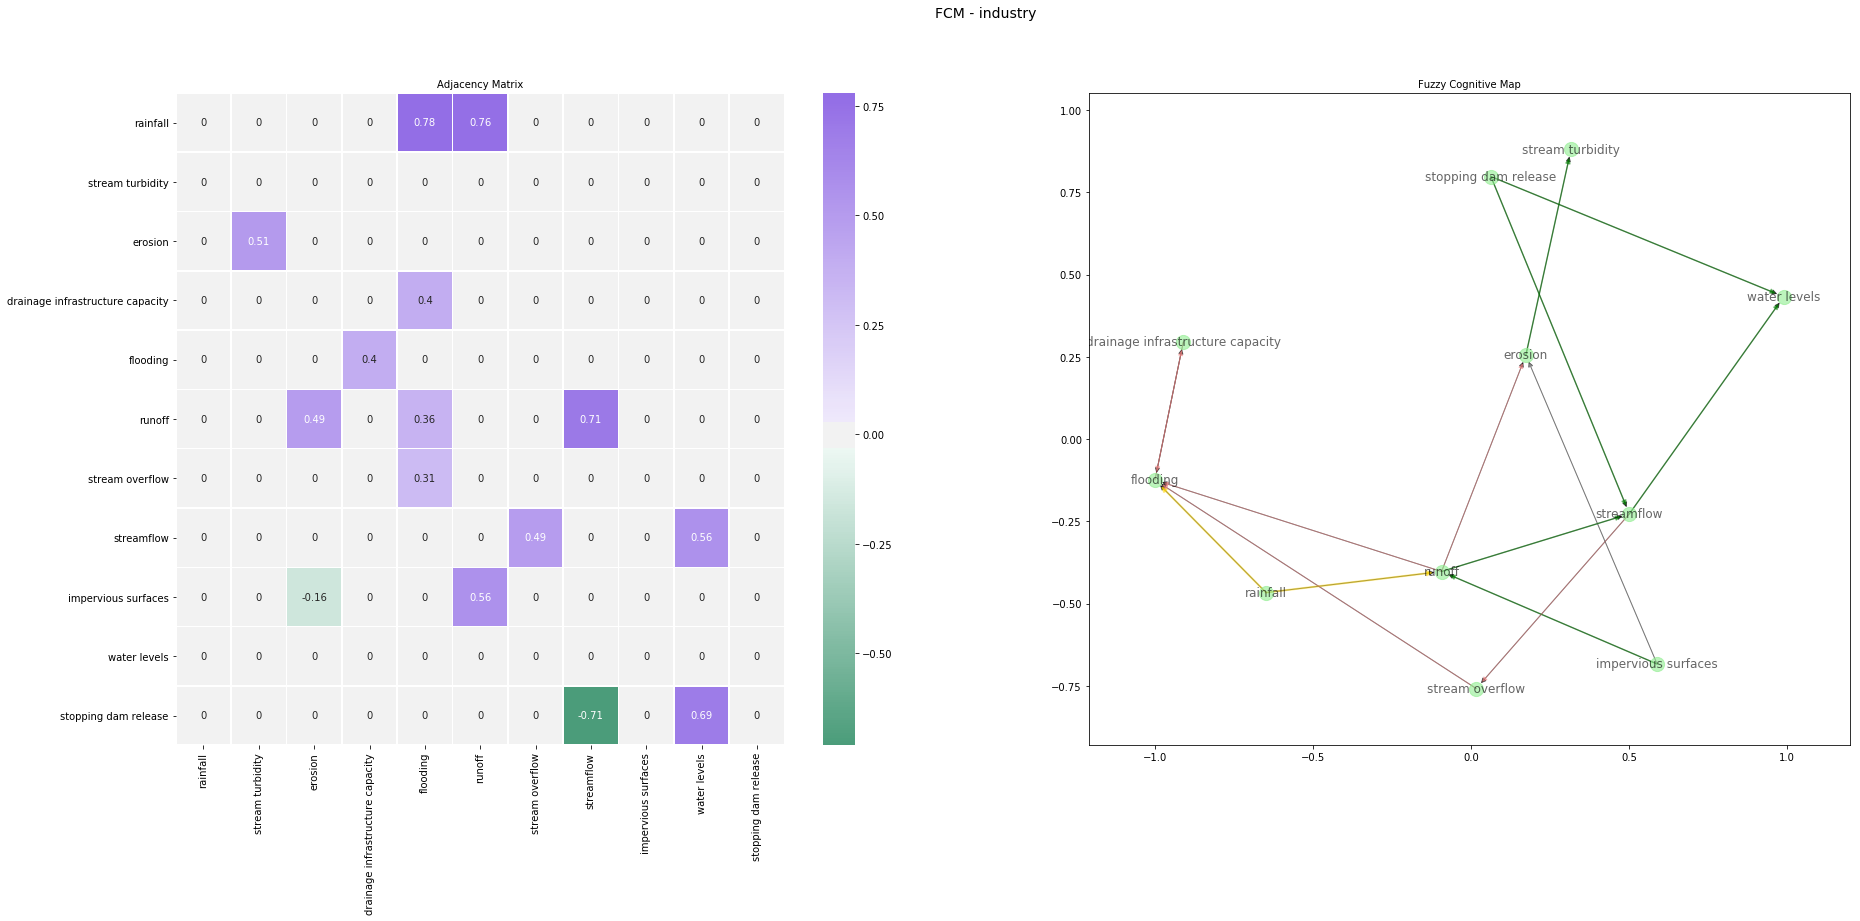

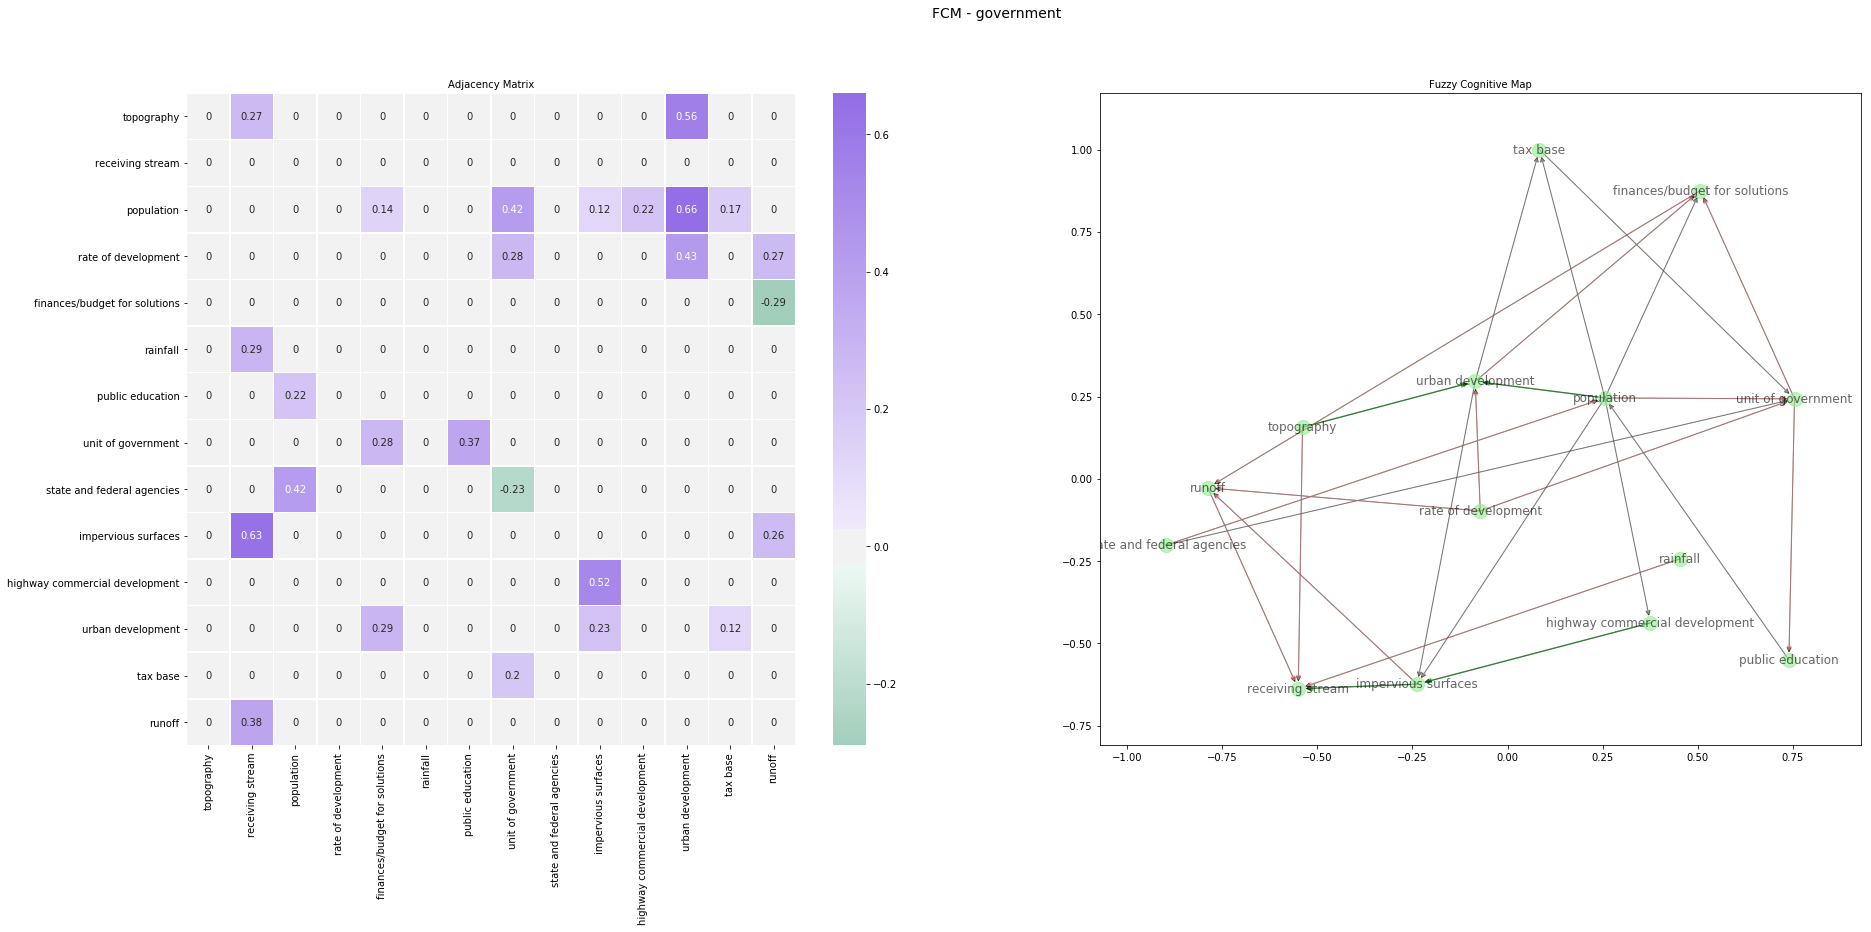

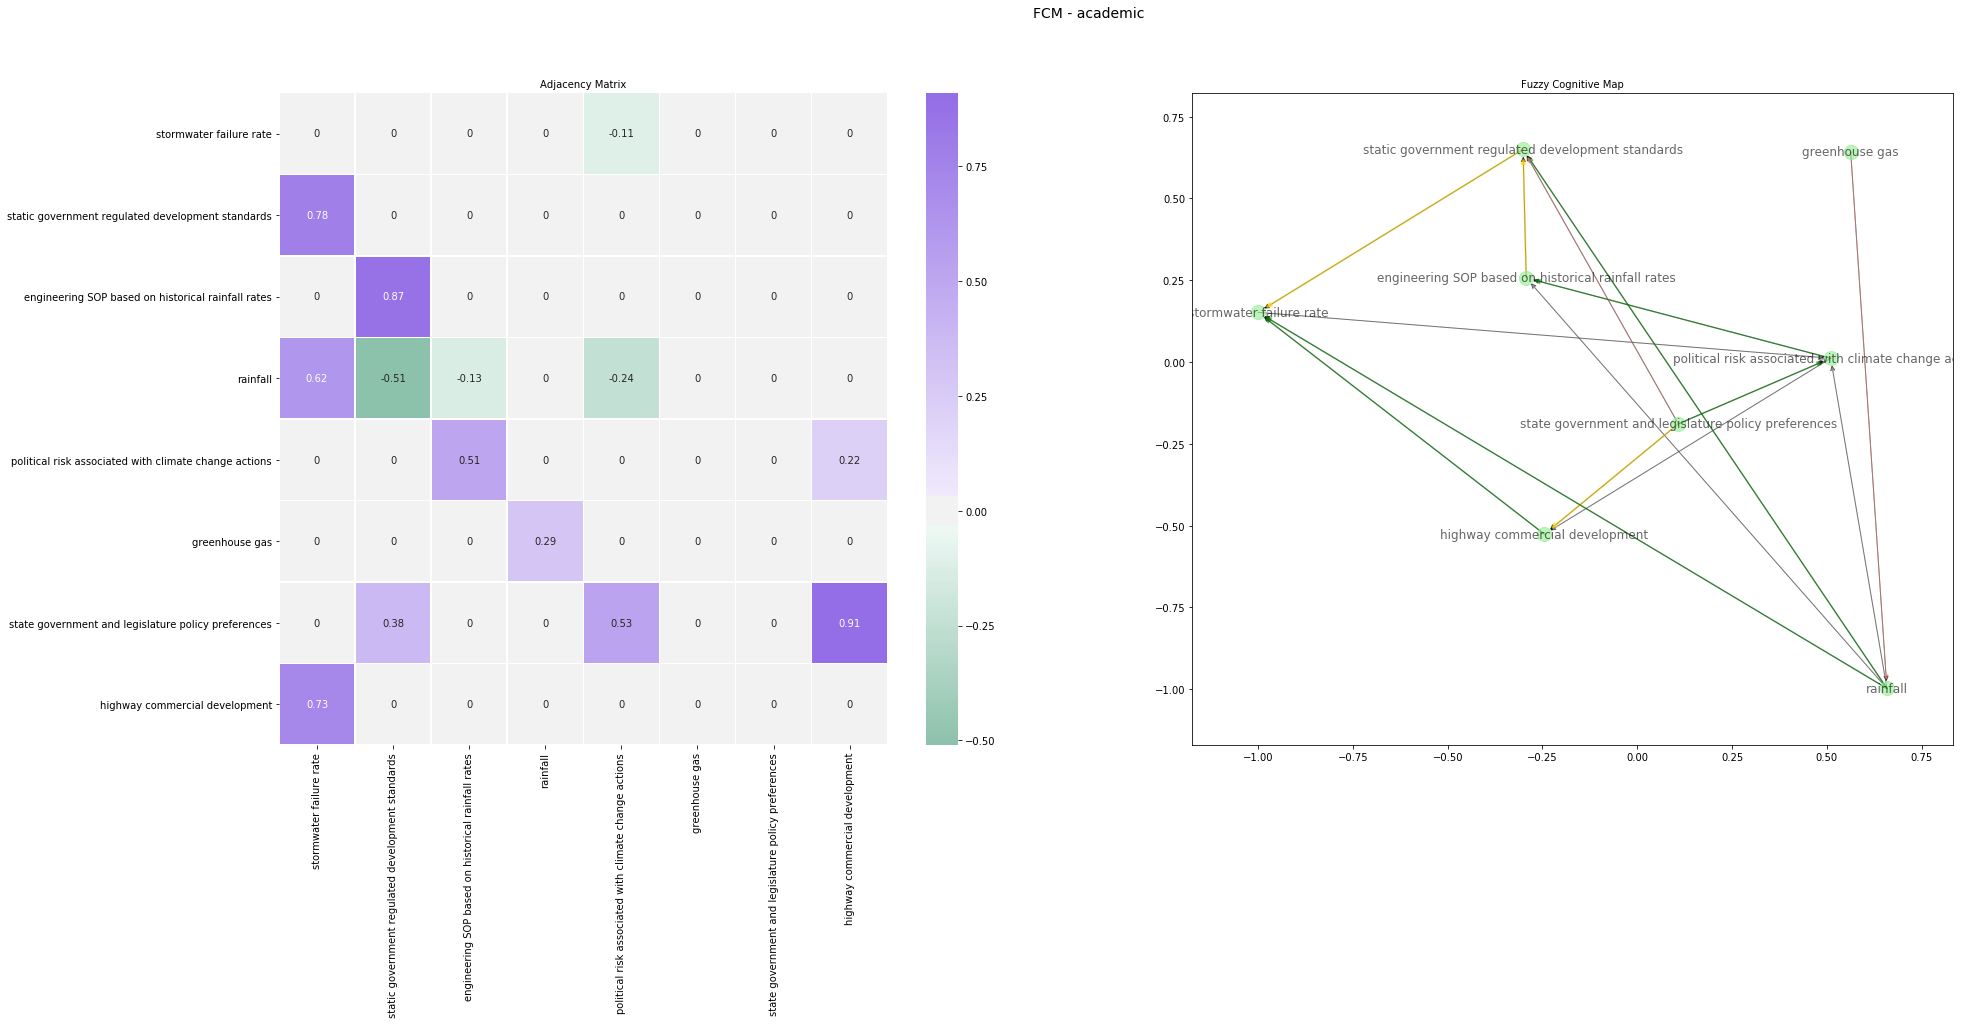

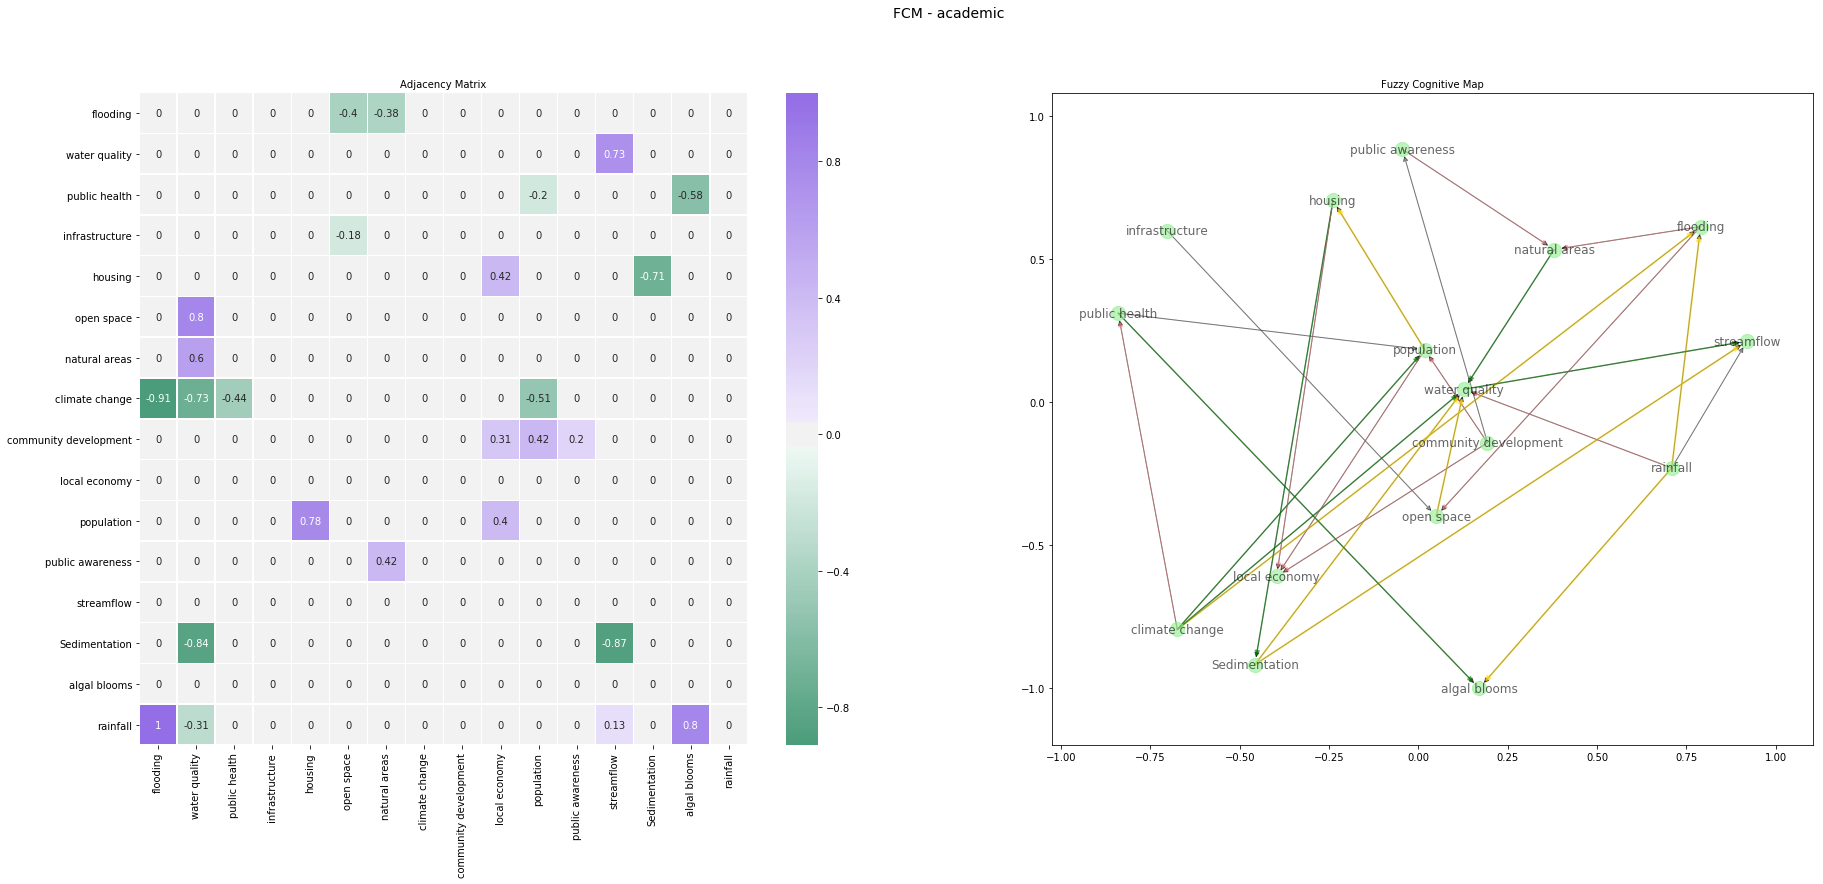

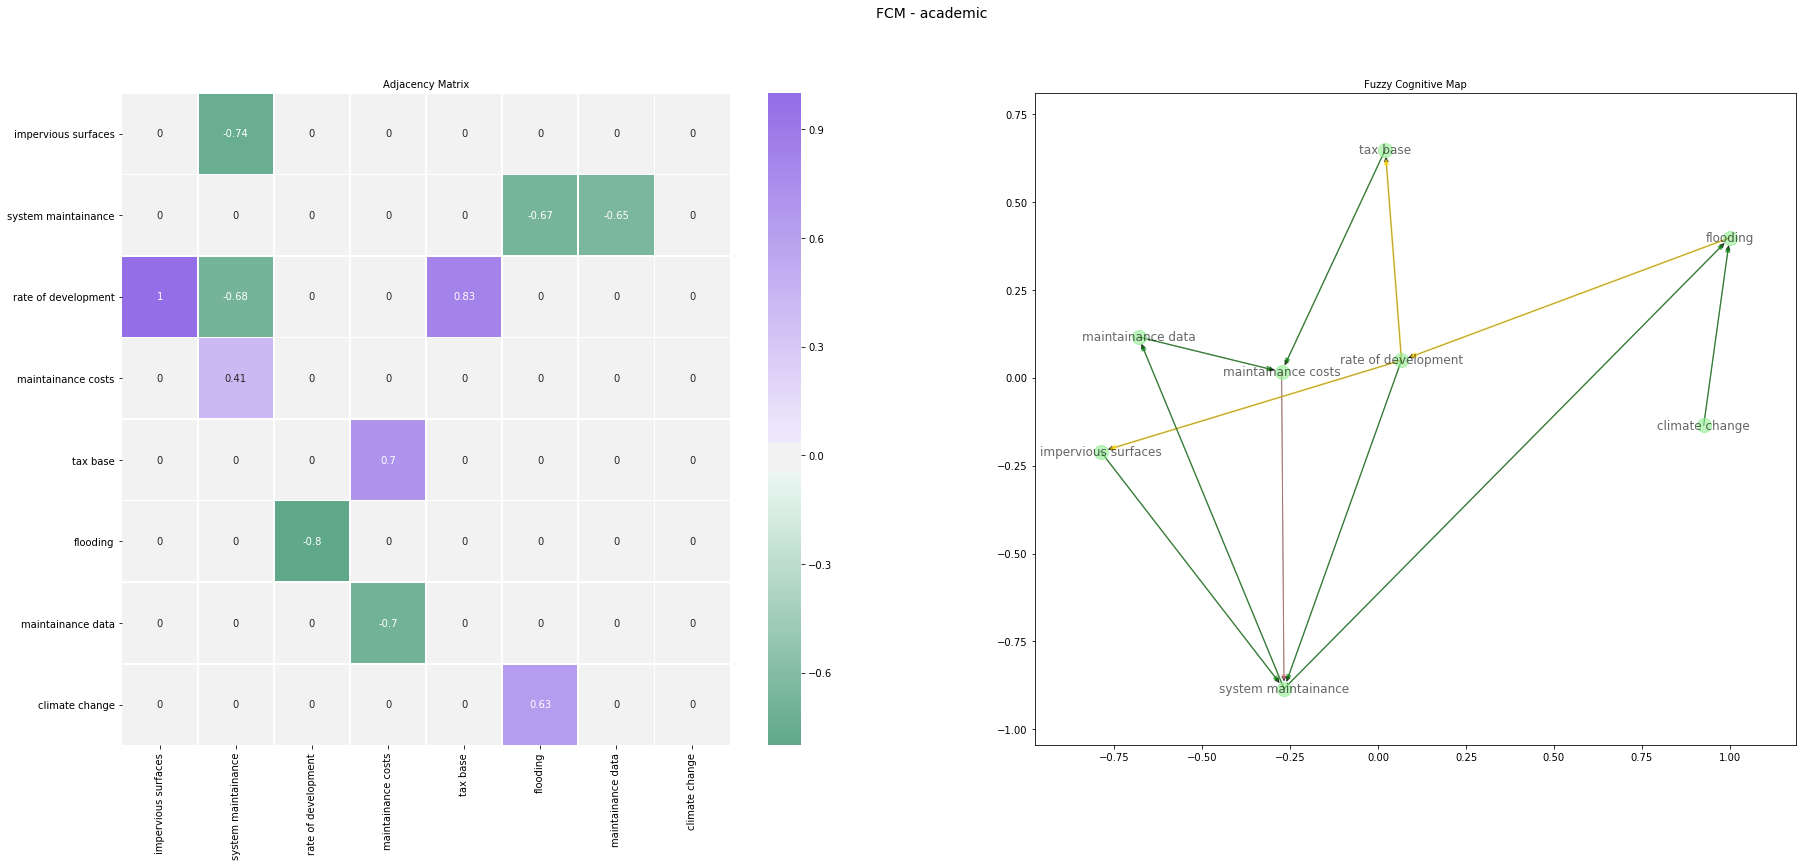

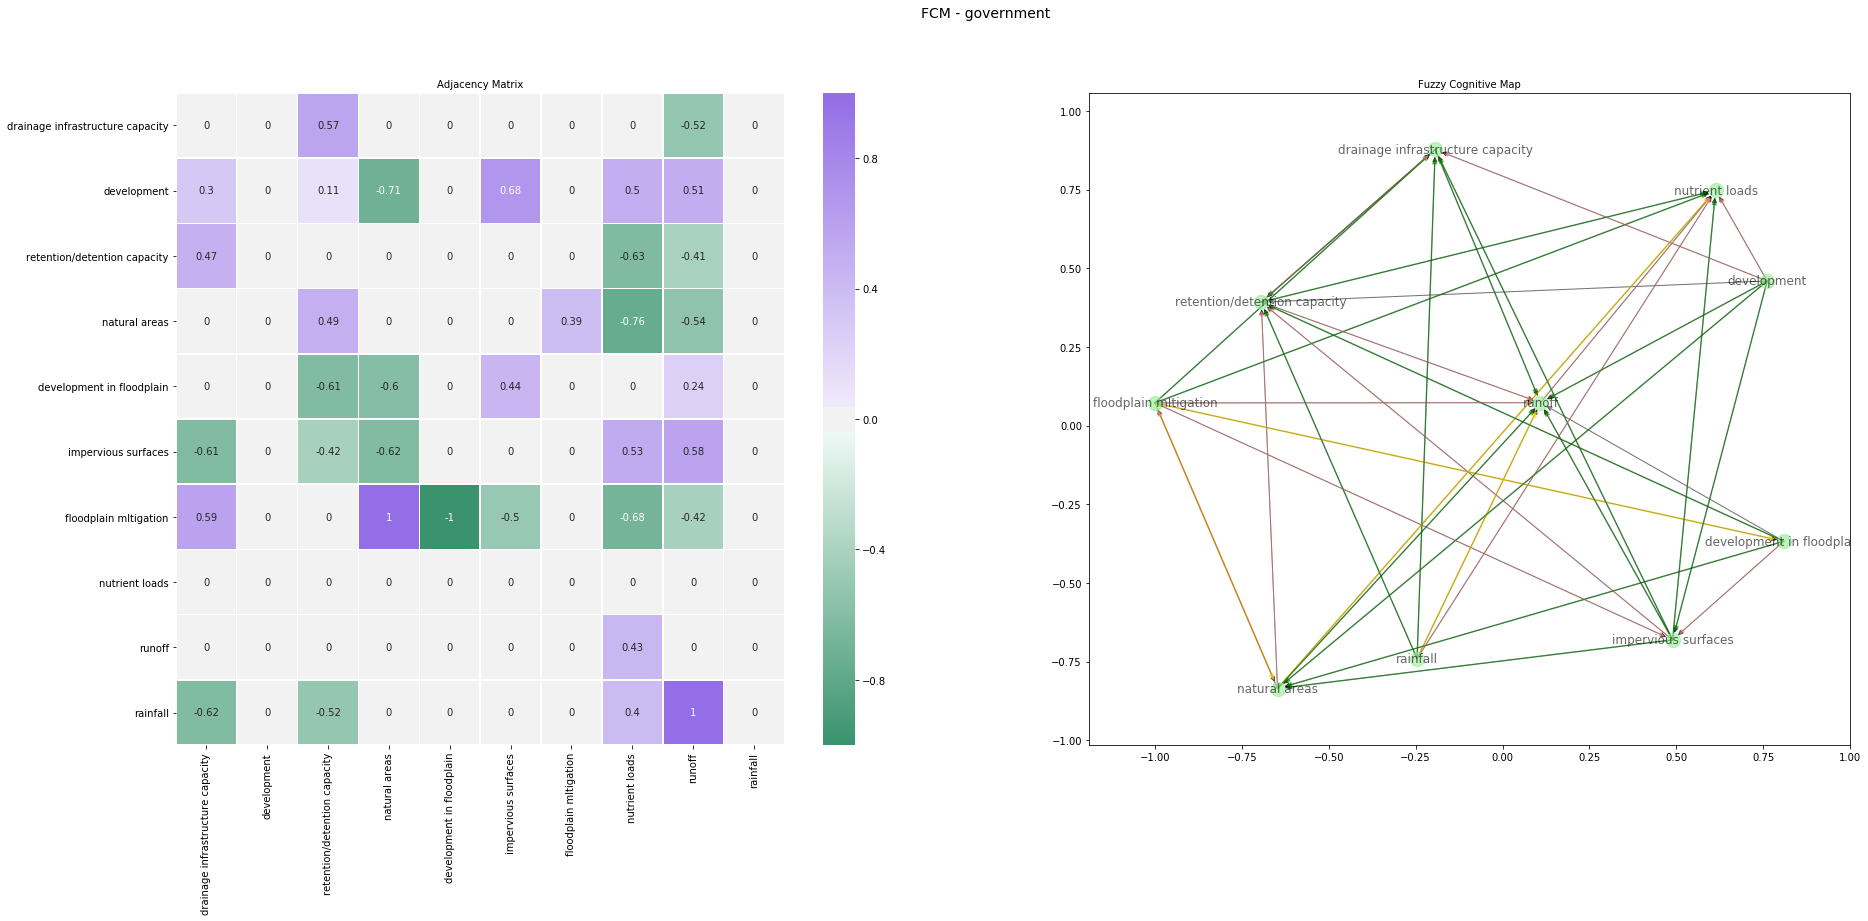

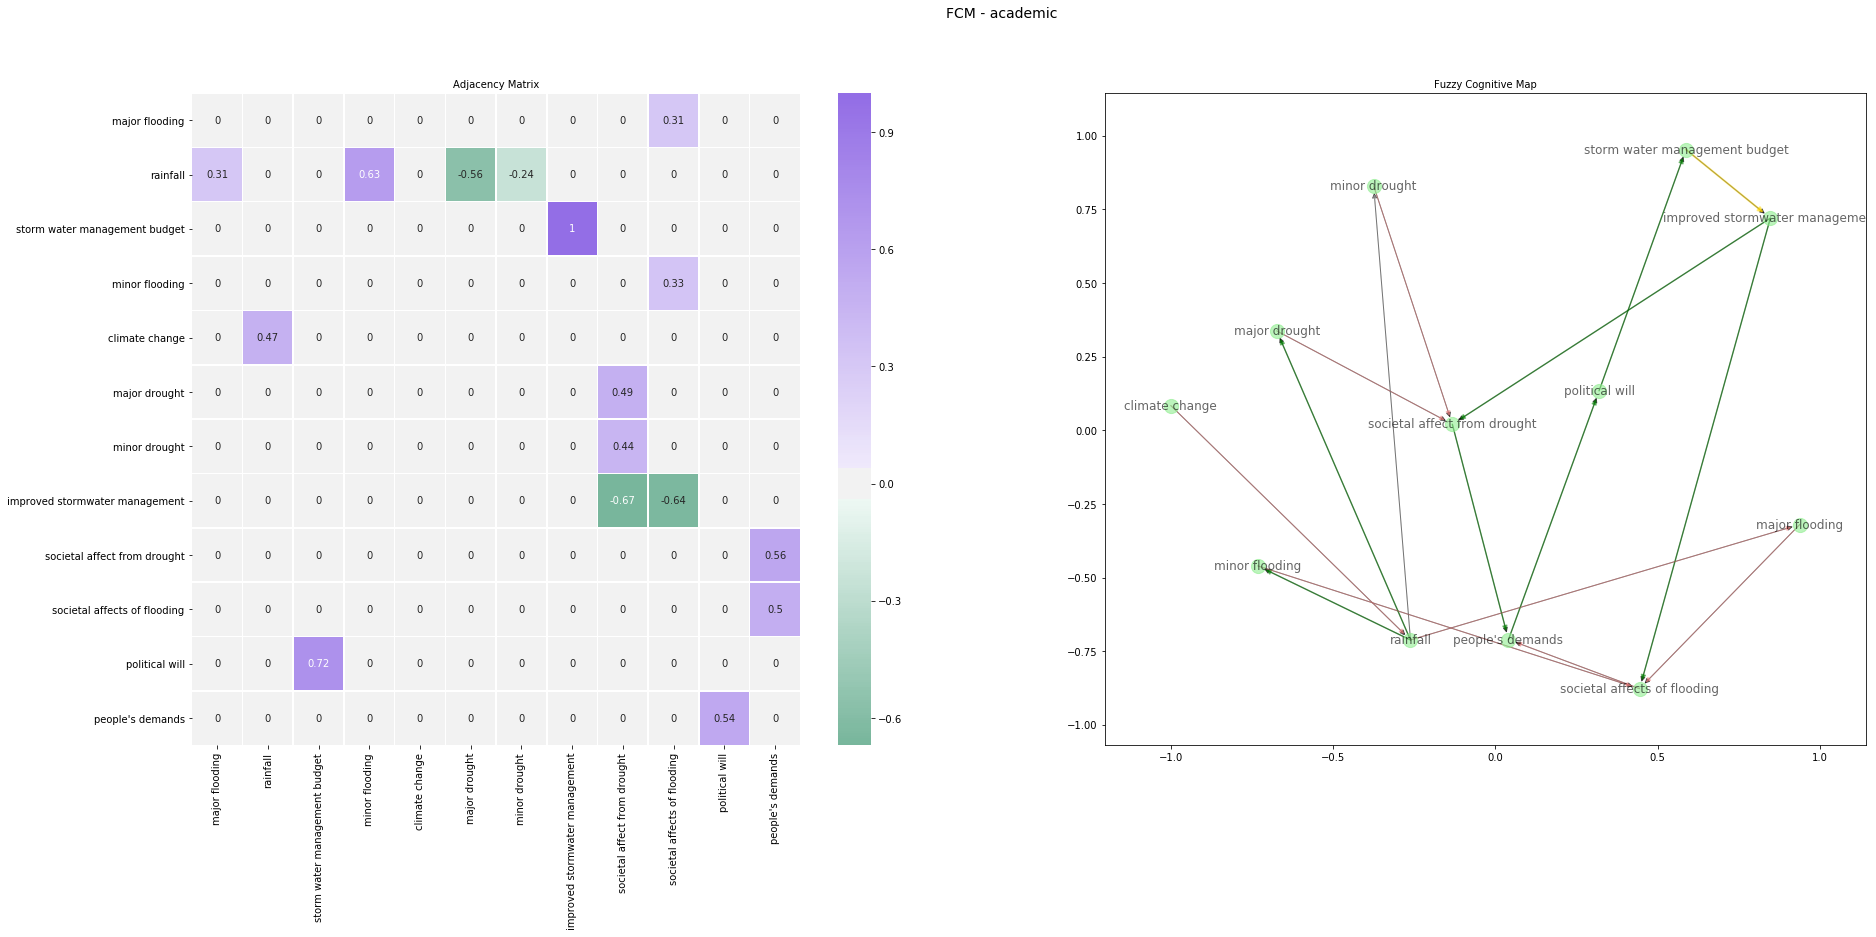

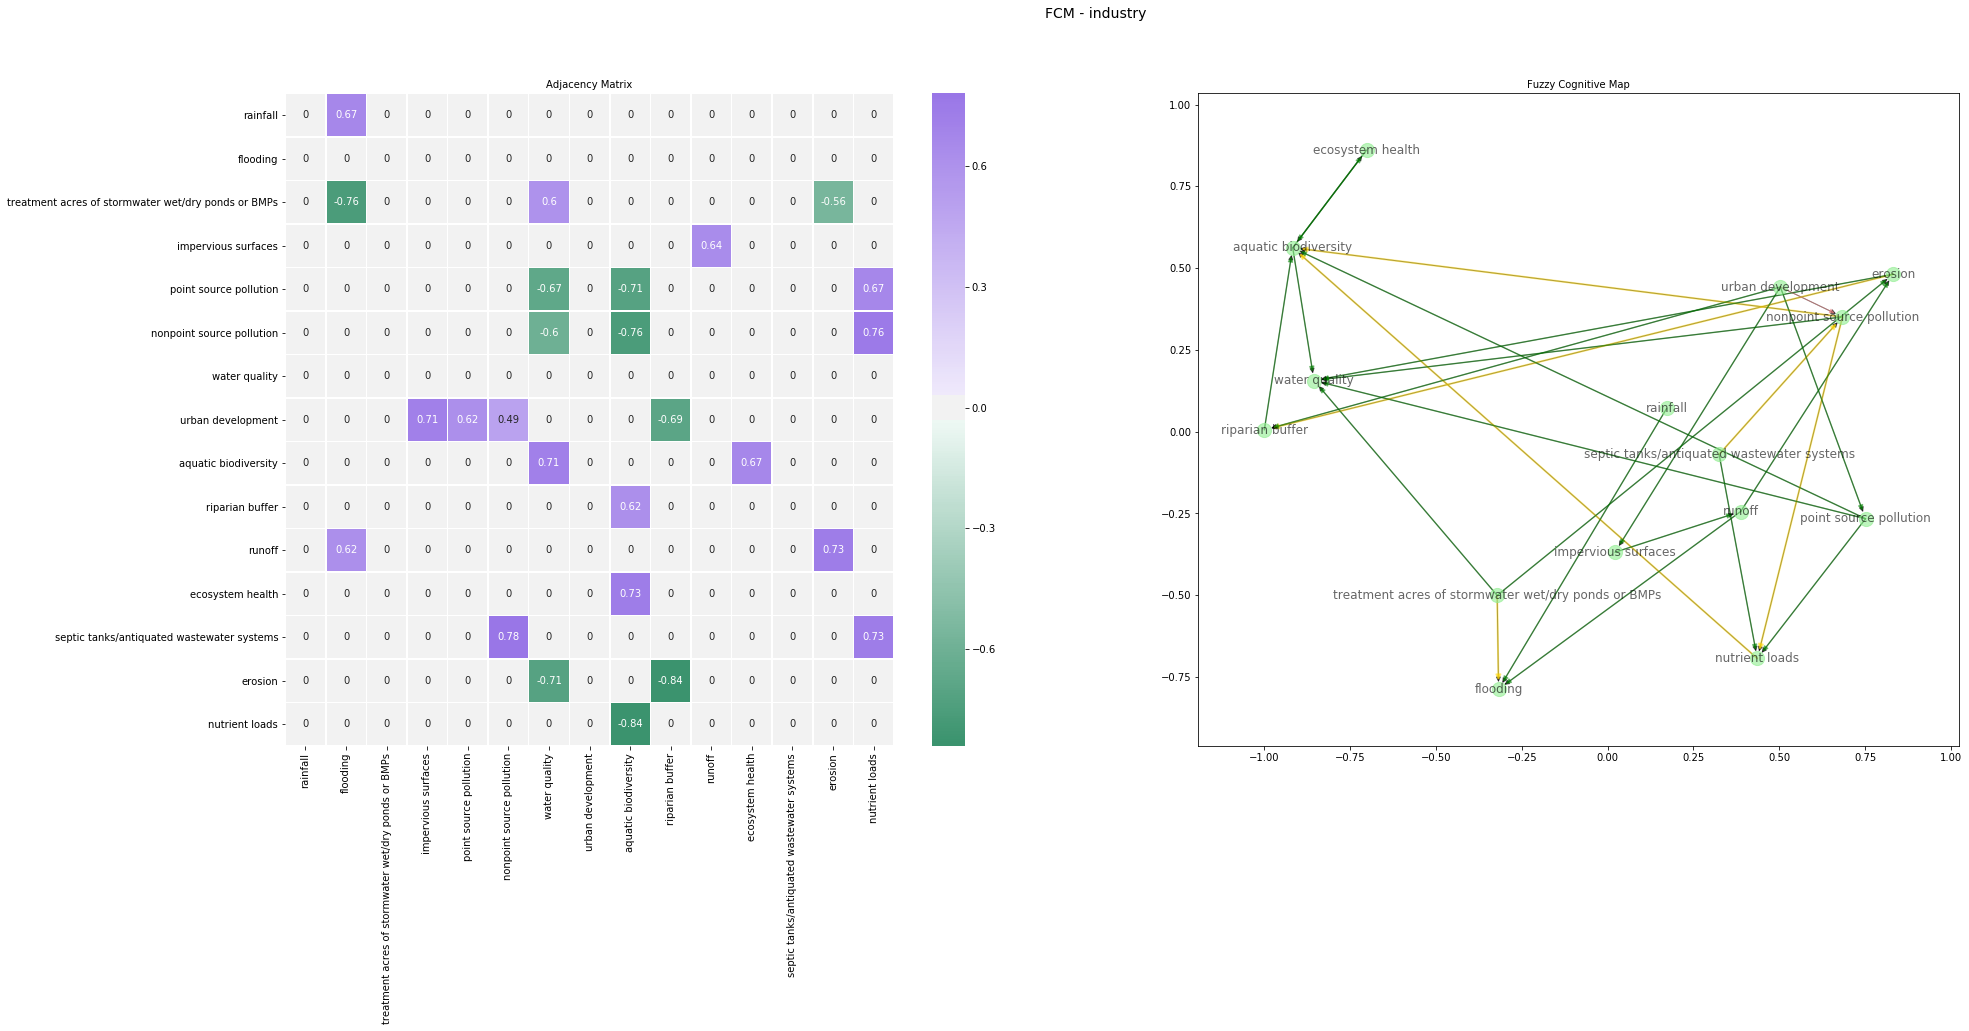

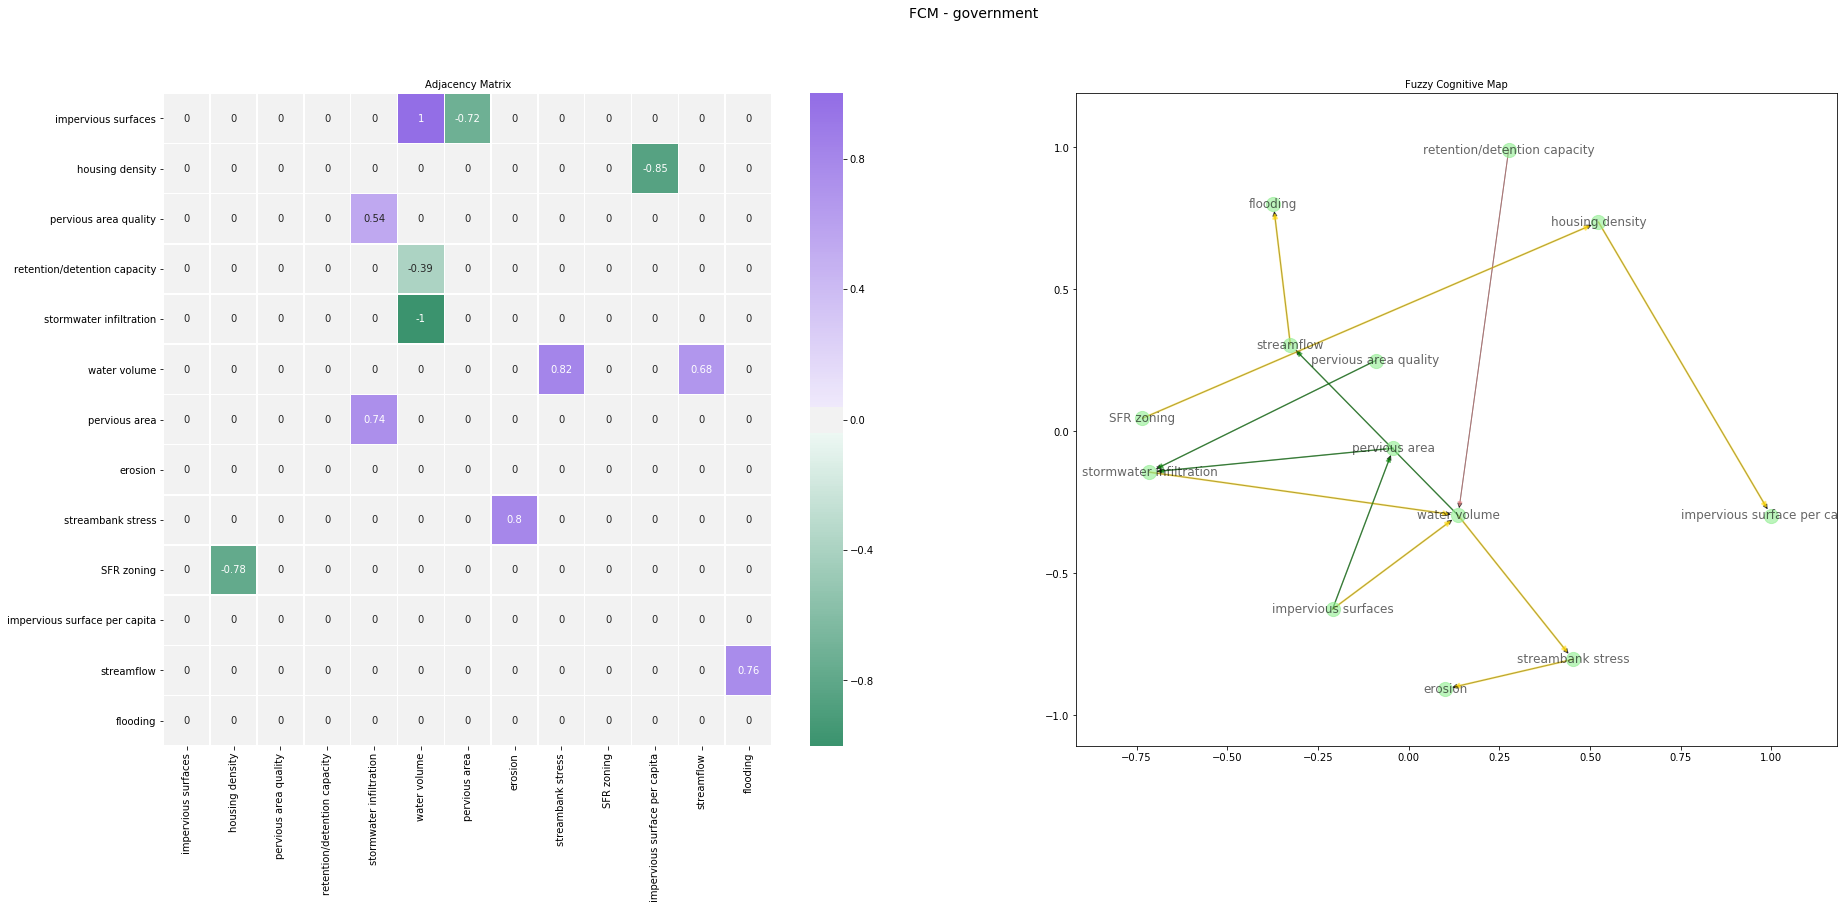

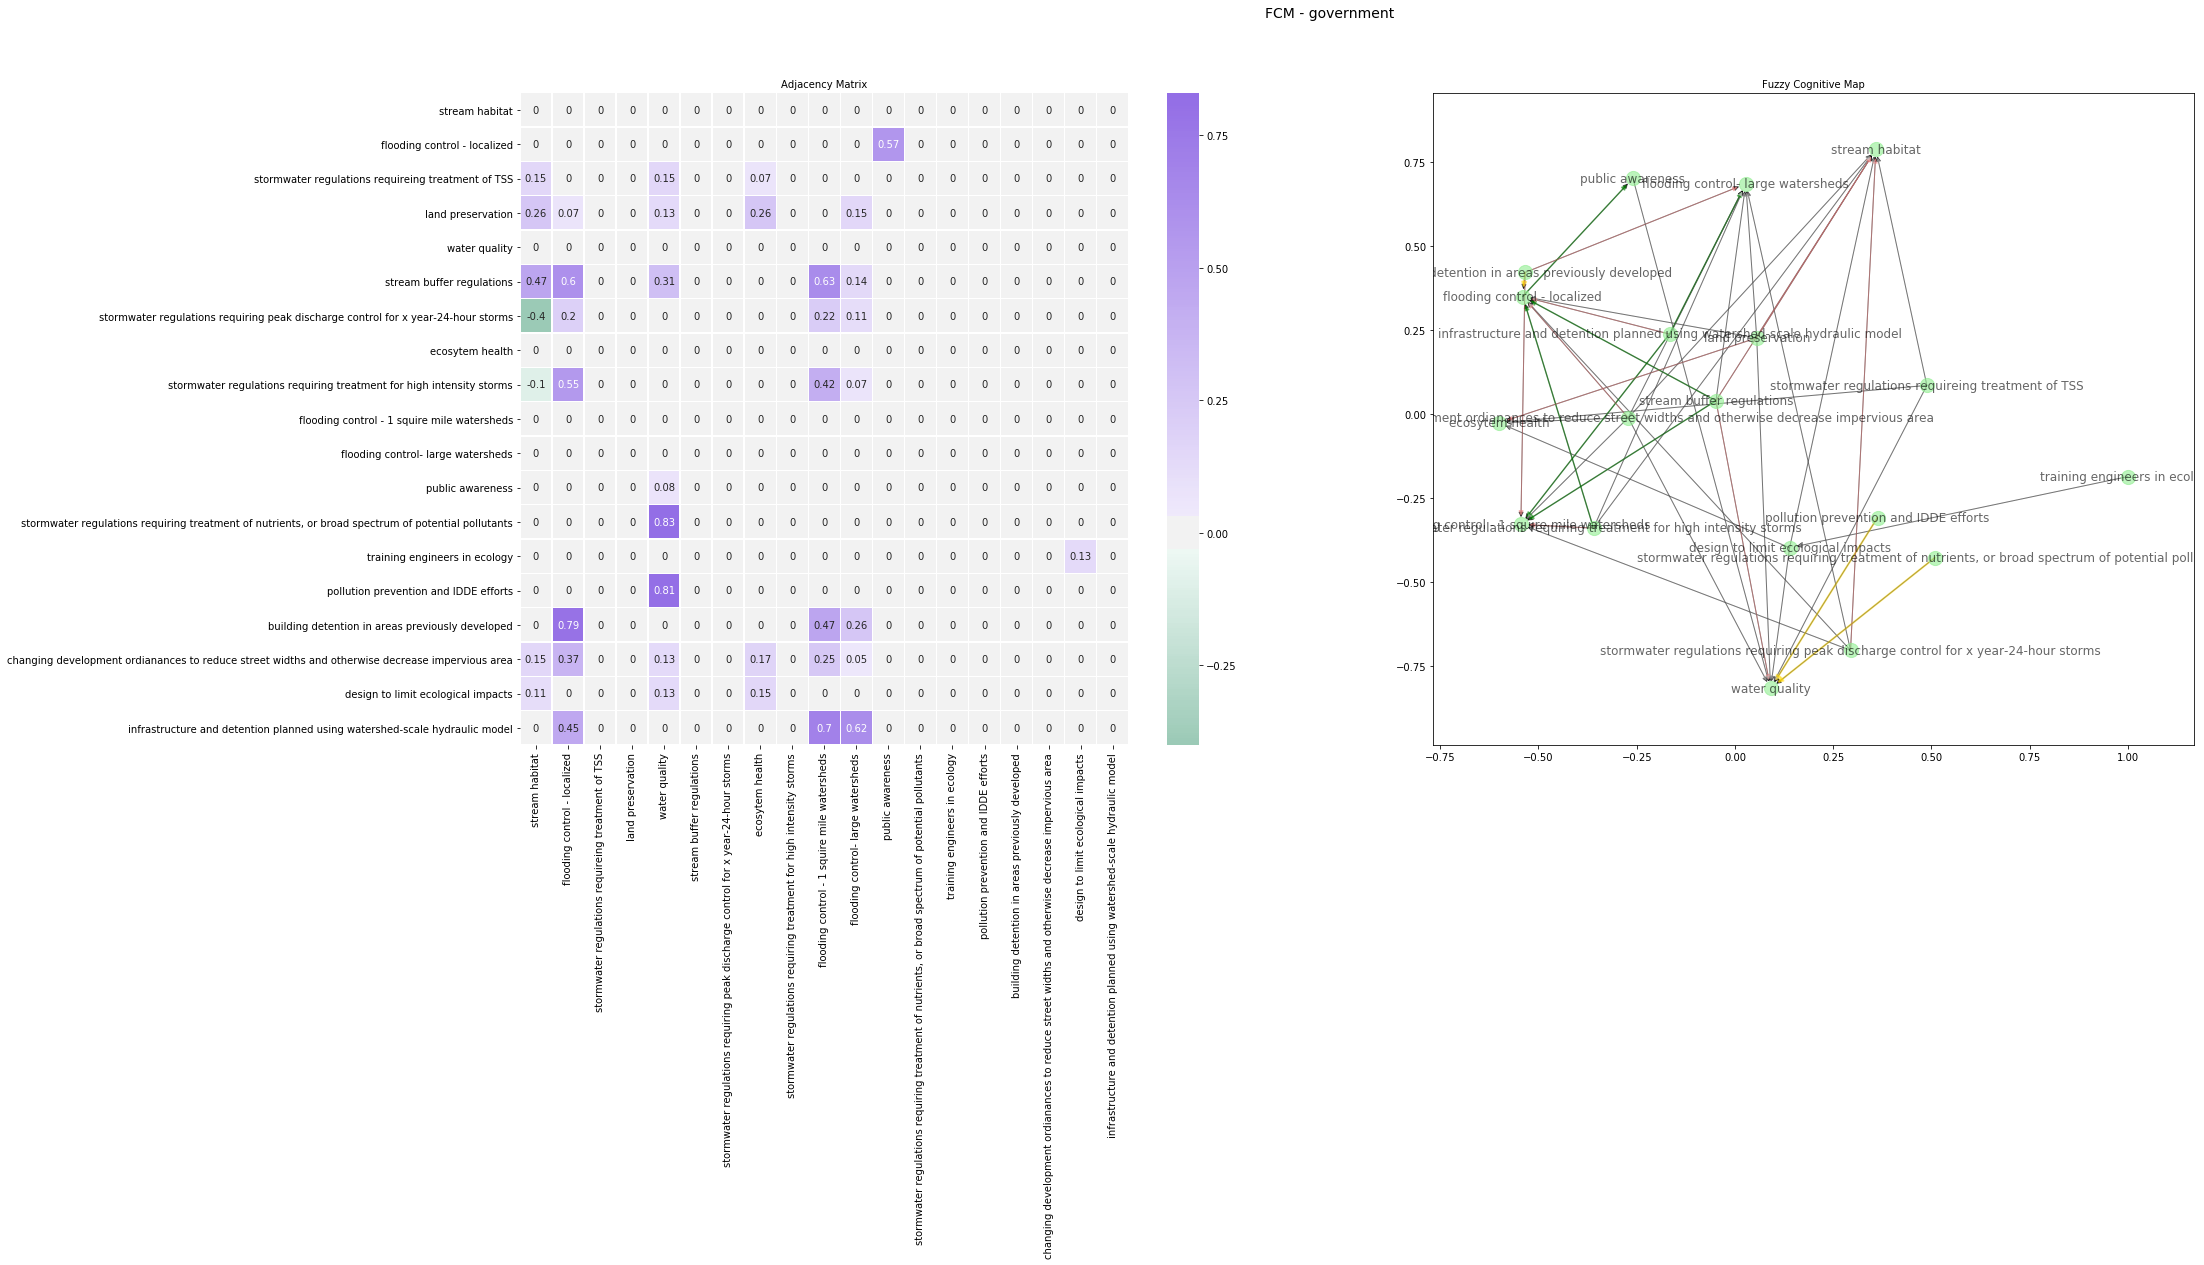

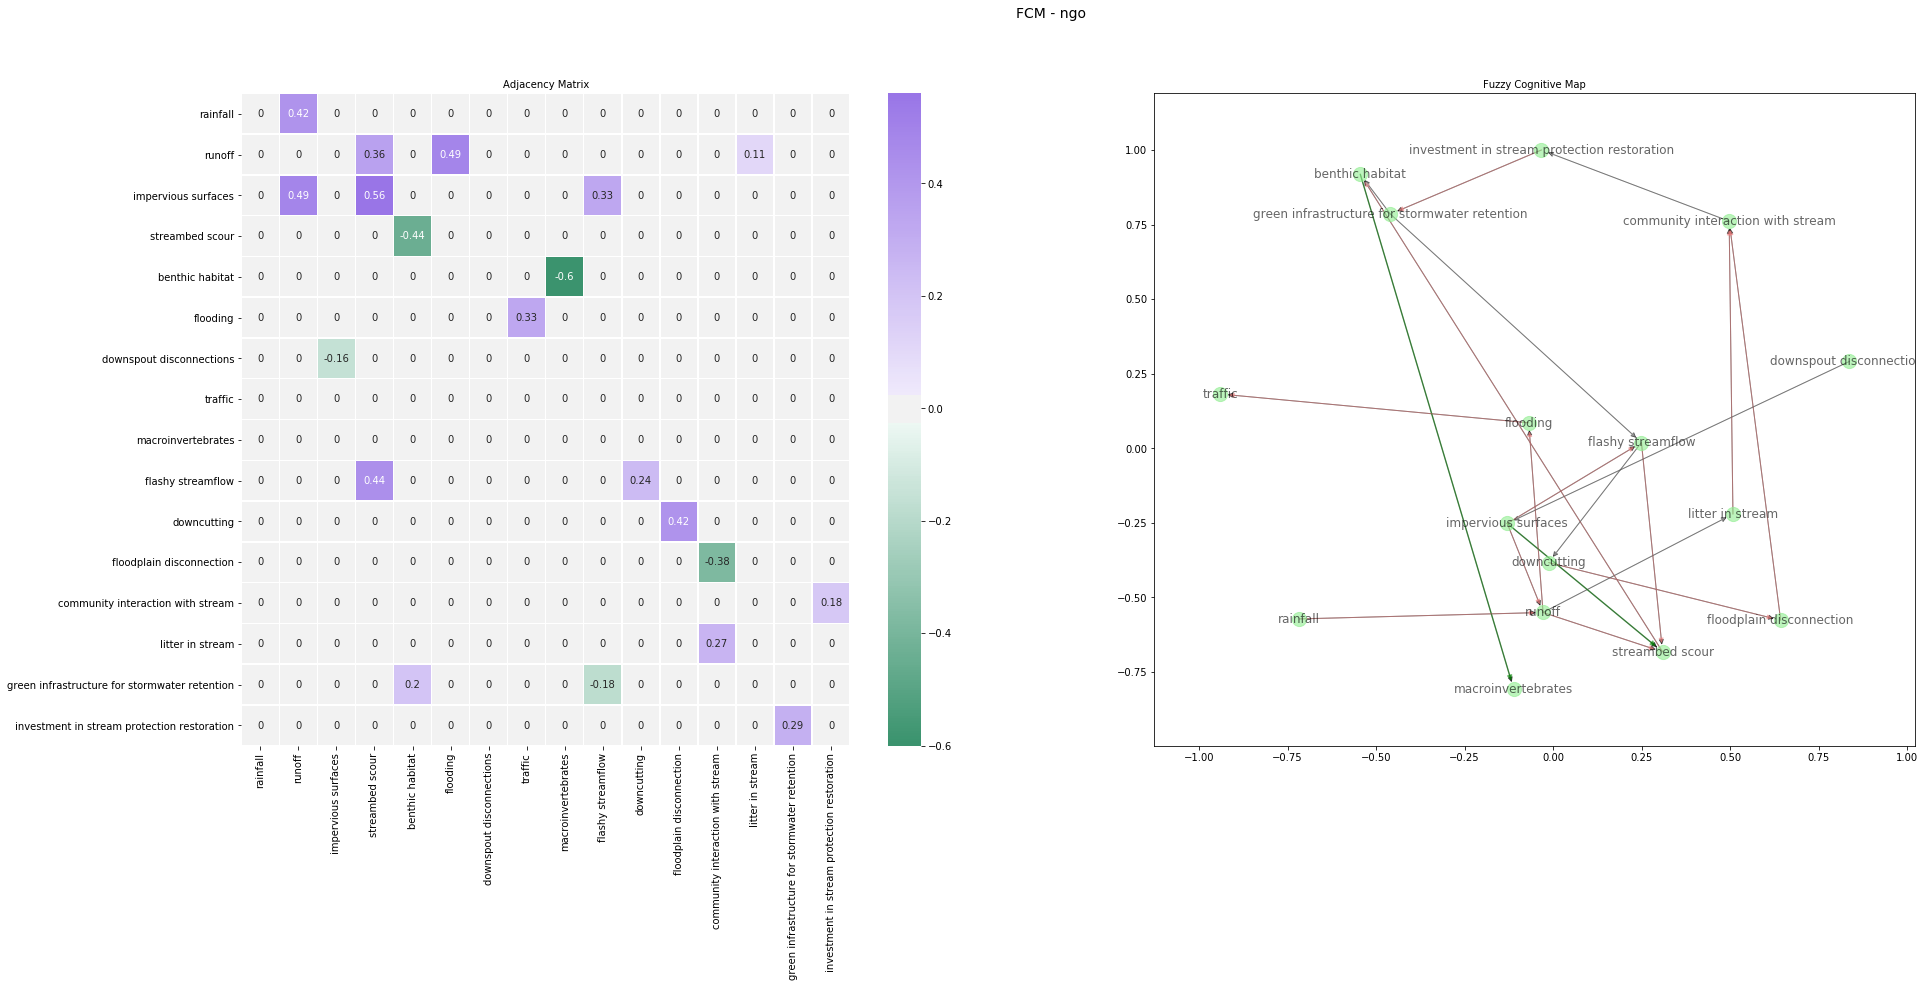

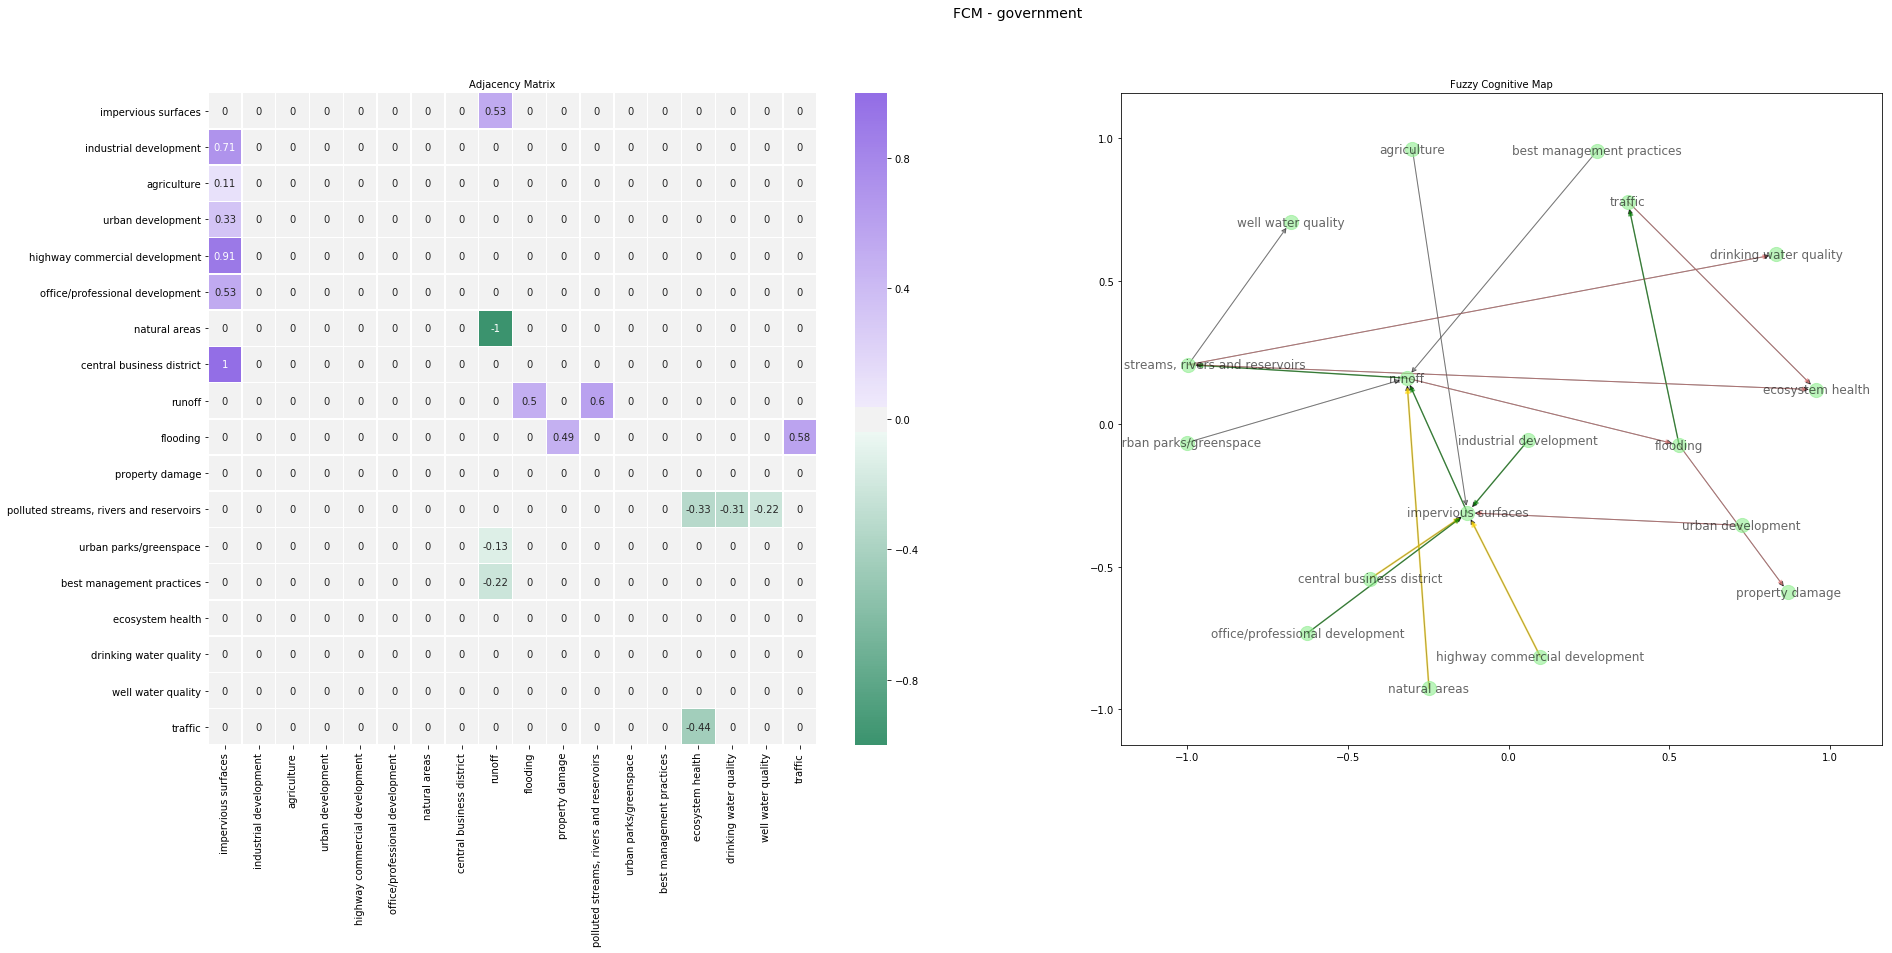

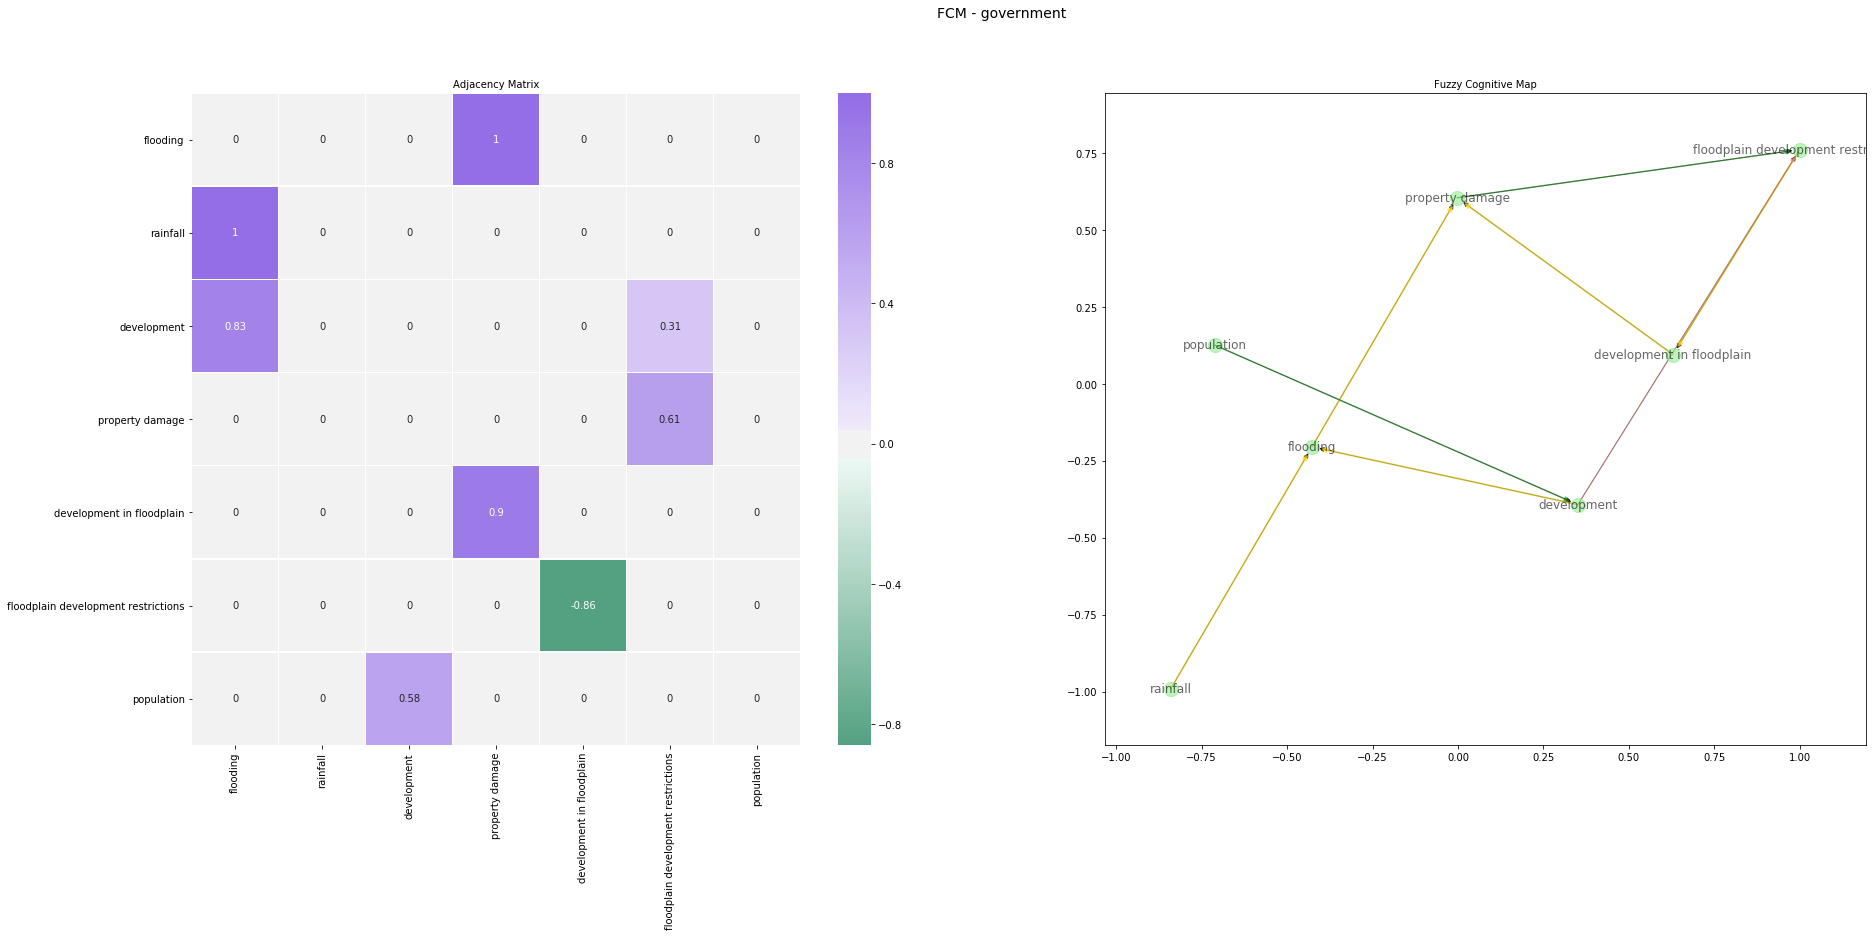

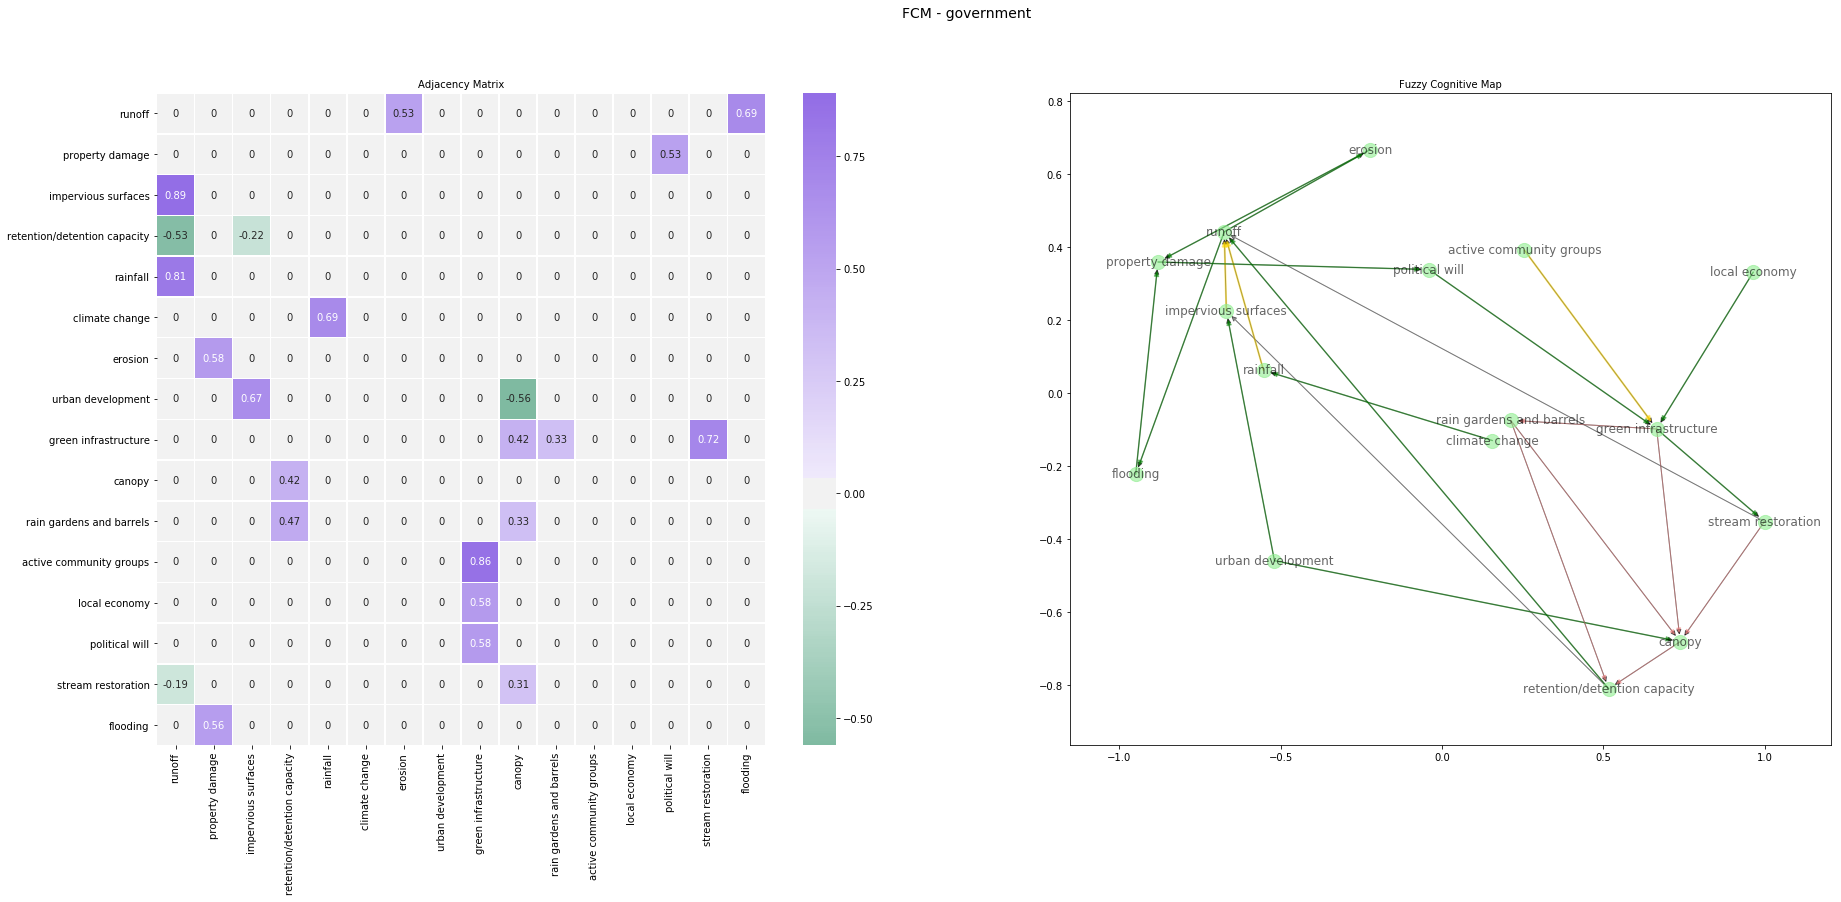

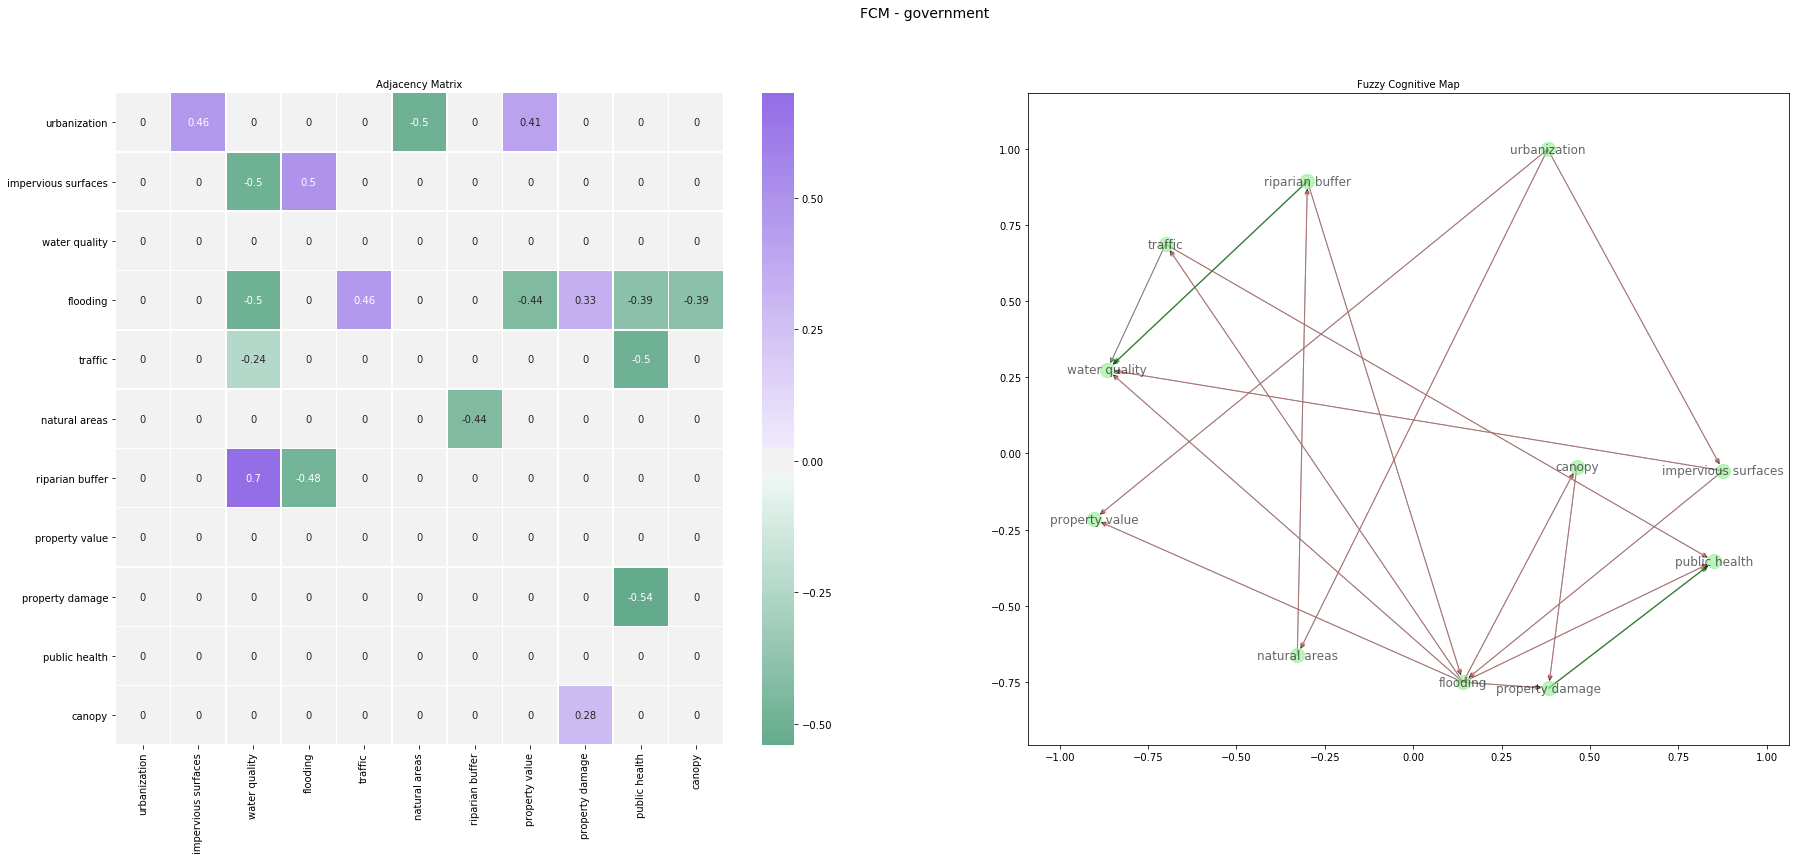

In [11]:
df_graph_stats_data = []  
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
All_ADJs =[]
all_data_frames = pd.DataFrame(columns=df_concepts['concept'].unique(), index=df_concepts['concept'].unique()).fillna(0)
for root, dirs, files in os.walk("./data", topdown=False):
    for name in files:
        if "allFCMs" not in name and name != ".DS_Store":
            file_location = os.path.join(root, name)
            participant_organization = name.split("_")[-1].split('.')[0]
            df = pd.read_excel(file_location,index_col=0).fillna(0)
            take_larger = lambda s1, s2: s1 if s1.sum() > s2.sum() else s2
            df_copy = all_data_frames.combine(df, take_larger, fill_value=0, overwrite=True)
            All_ADJs.append(df_copy.values)
            fig, (ax, ax1) = plt.subplots(1,2,figsize=(30,12))
            plt.suptitle('FCM - %s' % participant_organization, fontsize=14)
            ax.set_title("Adjacency Matrix", fontsize=10)

            sns.heatmap(df, annot=True, linewidths=.5, ax=ax, center=0,cmap=cmap)
            graph_stats = generate_map(df.values, df.columns, ax1)
            ax1.set_title("Fuzzy Cognitive Map", fontsize=10)
            graph_stats['type'] = participant_organization
            df_graph_stats_data.append(graph_stats)
            
df_graph_stats = pd.DataFrame(df_graph_stats_data)  



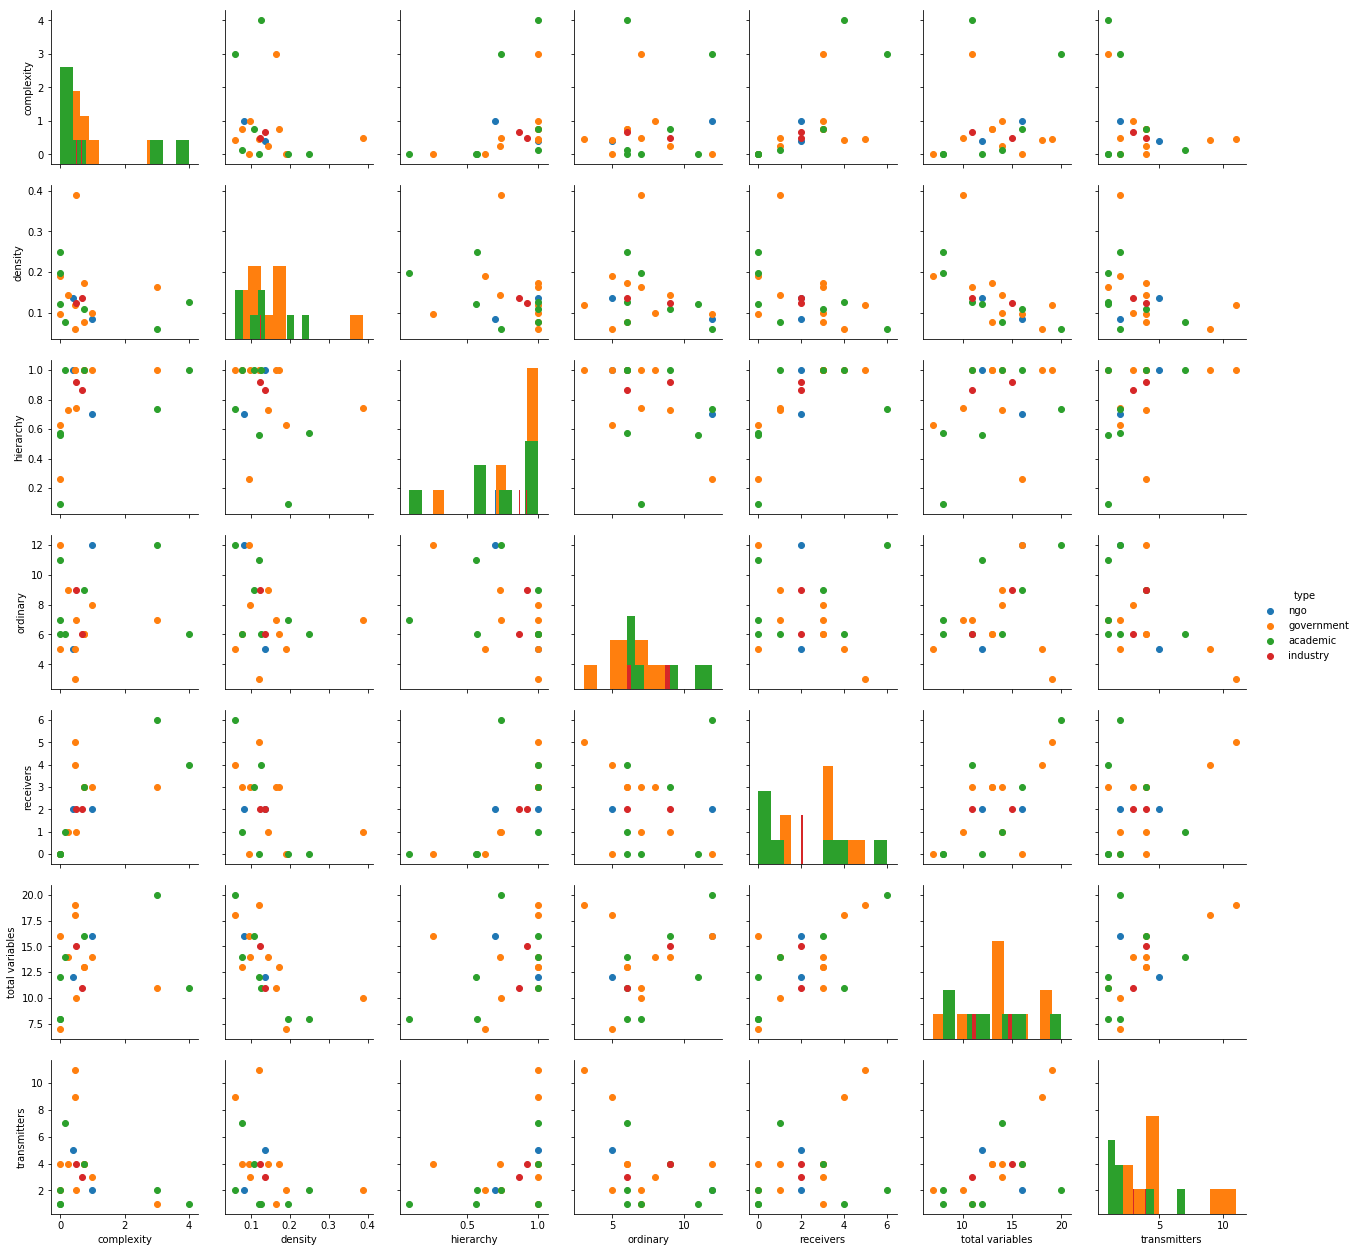

In [12]:
g = sns.PairGrid(df_graph_stats, hue="type")
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
# g = g.map_diag(sns.kdeplot, lw=3, legend=False)
g = g.add_legend()

### How do different stakeholder models compare to each other?

1. Total Variables

            count       mean       std   min   25%   50%   75%   max
type                                                                
academic      7.0  12.714286  4.347961   8.0   9.5  12.0  15.0  20.0
government   10.0  13.500000  3.628590   7.0  11.5  13.5  15.5  19.0
industry      2.0  13.000000  2.828427  11.0  12.0  13.0  14.0  15.0
ngo           2.0  14.000000  2.828427  12.0  13.0  14.0  15.0  16.0


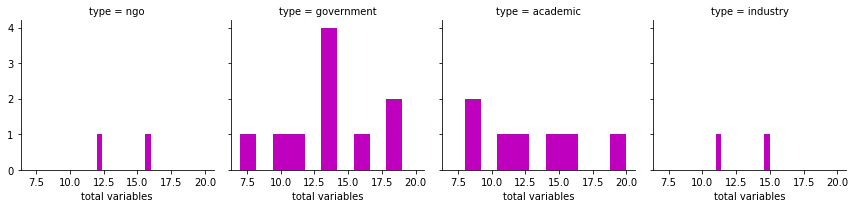

In [13]:
print(df_graph_stats.groupby('type')["total variables"].describe())
g= sns.FacetGrid(df_graph_stats, col="type")
g = g.map(plt.hist, "total variables", color="m")



2. Complexity (Receivers/transmitters) = R/T

> REWRITE IN OWN WORDS

* Large amount of receivers = FCM conciders many outcomes and situtations that result from the system
* Large amount of transmitters = Top down influencers (hierarchical system), flattens where causal arguments are not well elaborated

Complex maps have a large ratio because they define more utility outcomes and less controlling forcing functions. 

            count      mean       std  min       25%       50%    75%  \
type                                                                    
academic      7.0  1.127551  1.667499  0.0  0.000000  0.142857  1.875   
government   10.0  0.714899  0.864795  0.0  0.298611  0.477273  0.750   
industry      2.0  0.583333  0.117851  0.5  0.541667  0.583333  0.625   
ngo           2.0  0.700000  0.424264  0.4  0.550000  0.700000  0.850   

                 max  
type                  
academic    4.000000  
government  3.000000  
industry    0.666667  
ngo         1.000000  


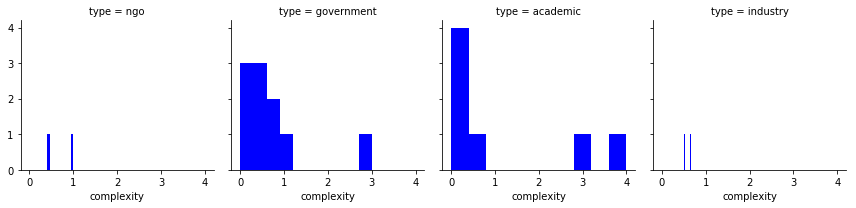

In [14]:
print(df_graph_stats.groupby('type')["complexity"].describe())
g= sns.FacetGrid(df_graph_stats, col="type")
g = g.map(plt.hist, "complexity", color="b")

3. Hierarchy

Graph hierarch ranges from zero to one graphs with a vaule of one are hierarchical while graphs with a value of zero are democratic (MacDonald, 1983; Özesmi and Özesmi, 2004). The graphs produced by stakeholders during the workshop are vary hierarchacl, which can be interpreded that stakeholders beleive that stormwater management practices in the Triangle, NC are not easy to modify (Sandell, 1996; Özesmi and Özesmi, 2004). 

            count      mean       std       min       25%       50%       75%  \
type                                                                            
academic      7.0  0.709138  0.336000  0.090909  0.566964  0.739130  1.000000   
government   10.0  0.835950  0.248645  0.260870  0.733791  1.000000  1.000000   
industry      2.0  0.894872  0.039888  0.866667  0.880769  0.894872  0.908974   
ngo           2.0  0.850000  0.212132  0.700000  0.775000  0.850000  0.925000   

                 max  
type                  
academic    1.000000  
government  1.000000  
industry    0.923077  
ngo         1.000000  


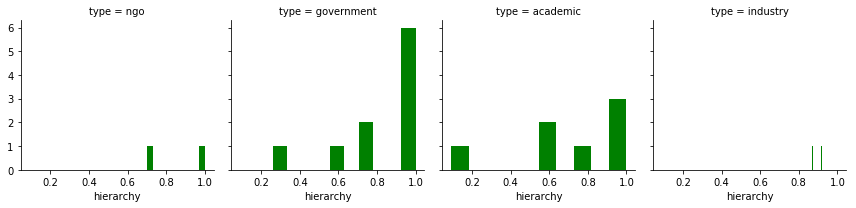

In [15]:
print(df_graph_stats.groupby('type')["hierarchy"].describe())
g= sns.FacetGrid(df_graph_stats, col="type")
g = g.map(plt.hist, "hierarchy", color="g")

                                                    centrality
upstream inputs                                       0.974286
treatment acres of stormwater wet/dry ponds or ...    0.848095
septic tanks/antiquated wastewater systems            0.842857
development in floodplain                             0.762857
major flooding                                        0.313333
maintainance costs                                    0.291905
urban parks/greenspace                                0.279524
climate change                                        0.264762
consistently flooded areas                            0.195714
rain gardens and barrels                              0.189048
impervious surface per capita                         0.178095
allowable construction in floodplains                 0.171429
Sedimentation                                         0.167619
development planning and policies                     0.167143
litter in stream                                      0

{'ordinary': 79,
 'receivers': 25,
 'transmitters': 49,
 'total variables': 153,
 'density': 0.01130890952872377,
 'complexity': 0.5102040816326531,
 'hierarchy': 0.6463878326996197}

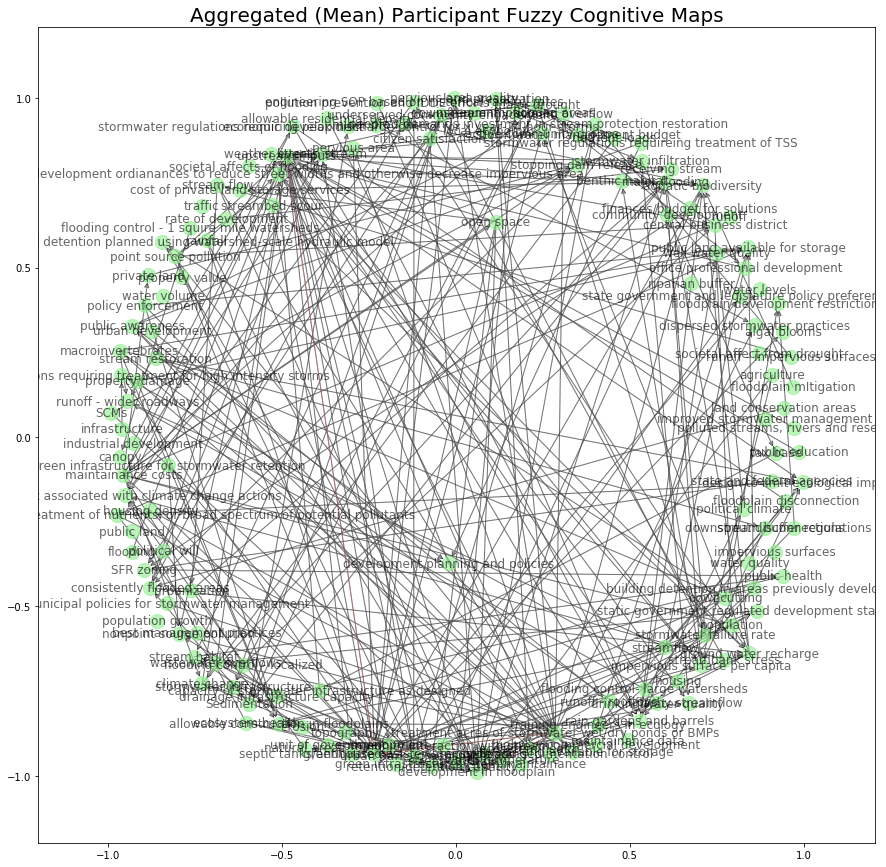

In [16]:
Adj_aggregated_FCM = np.mean(np.asarray(All_ADJs), axis=0)
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title("Aggregated (Mean) Participant Fuzzy Cognitive Maps", fontsize=20)

generate_map(Adj_aggregated_FCM, df_concepts['concept'].unique(),ax)

Text(0.5, 1.0, 'Combined Model Variables > 2')

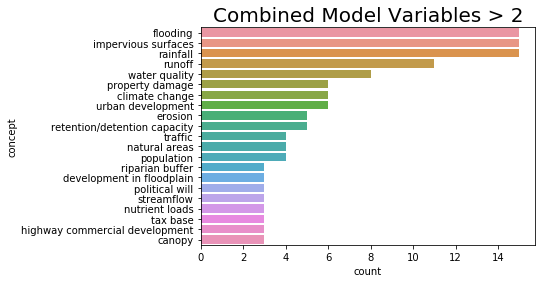

In [17]:
df_counts = df_concepts['concept'].value_counts()
filtered_concepts = df_counts[df_counts > 2].index
fig,ax= plt.subplots()
sns.countplot(y="concept", data=df_concepts,ax=ax, order = filtered_concepts)
ax.set_title(("Combined Model Variables > 2"), fontsize=20)

In [18]:
All_ADJs =[]
all_data_frames = pd.DataFrame(columns=filtered_concepts, index=filtered_concepts).fillna(0)
for root, dirs, files in os.walk("./data", topdown=False):
    for name in files:
        if "allFCMs" not in name and name != ".DS_Store":
            file_location = os.path.join(root, name)
            participant_organization = name.split("_")[-1].split('.')[0]
            df = pd.read_excel(file_location,index_col=0).fillna(0)
            take_larger = lambda s1, s2: s1 if s1.sum() > s2.sum() else s2
            df_copy = all_data_frames.combine(df, take_larger, fill_value=0, overwrite=True)
            All_ADJs.append(df_copy.loc[filtered_concepts,filtered_concepts].values)
            
df_graph_stats = pd.DataFrame(df_graph_stats_data)  


In [19]:
def aggregate_mean(adj_matrices, concepts, zeros=False):
    """Aggregates arithmatic mean of adjacency matrices.
    
    :param adj_matrices: List of FCM adjaceny matrices.
    :param concepts: List of variable names used to label graph adjaceny matrix.
    :param zeros: Determines if zeros are included in arithmatic mean calculation.
    
    :return: np.array of the arithmatic mean of adjacency matrices.
    """
    from functools import reduce
    from statistics import mean as mean
    n_concepts = len(concepts)
    count = np.zeros((n_concepts,n_concepts))
    adj_ag = np.zeros((n_concepts,n_concepts))

    #Create matrix of the sums of all adjecency matricies
    adj = (reduce((lambda x, y: x + y), adj_matrices))

    adj_copy = np.copy(adj)    
    
    if zeros:
        for i in range (n_concepts):
            for j in range (n_concepts):
                a = [ind[i,j] for ind in adj_matrices]
                adj_ag[i,j] = mean(a)
    else:
        #Creates a variable frequency matrix. 
        for fcm in adj_matrices:
            for i in range (n_concepts):
                for j in range (n_concepts):
                    if fcm[i,j] != 0:
                        count[i,j] +=1

        #Calculates the mean of all matrices by not including zero values.
        for i in range (n_concepts):
            for j in range (n_concepts):
                if count[i,j] == 0:
                    adj_ag[i,j] = 0
                else:
                    adj_ag[i,j] = adj_copy[i,j]/count[i,j]
    return adj_ag
    

## Mean of all FCMs (Exclude edges with weight equalling zero)

                                centrality
impervious surfaces               4.116667
development in floodplain         3.860000
runoff                            3.334345
flooding                          2.908631
rainfall                          2.850476
property damage                   2.840000
population                        2.610000
nutrient loads                    1.510000
streamflow                        1.470000
urban development                 1.311667
traffic                           1.216667
riparian buffer                   1.020000
erosion                           1.003333
highway commercial development    0.935000
tax base                          0.840000
retention/detention capacity      0.603333
political will                    0.530000
water quality                     0.440000
climate change                   -0.246667
canopy                           -0.320000
natural areas                    -0.920000


{'ordinary': 14,
 'receivers': 4,
 'transmitters': 3,
 'total variables': 21,
 'density': 0.10476190476190476,
 'complexity': 1.3333333333333333,
 'hierarchy': 0.8863636363636364}

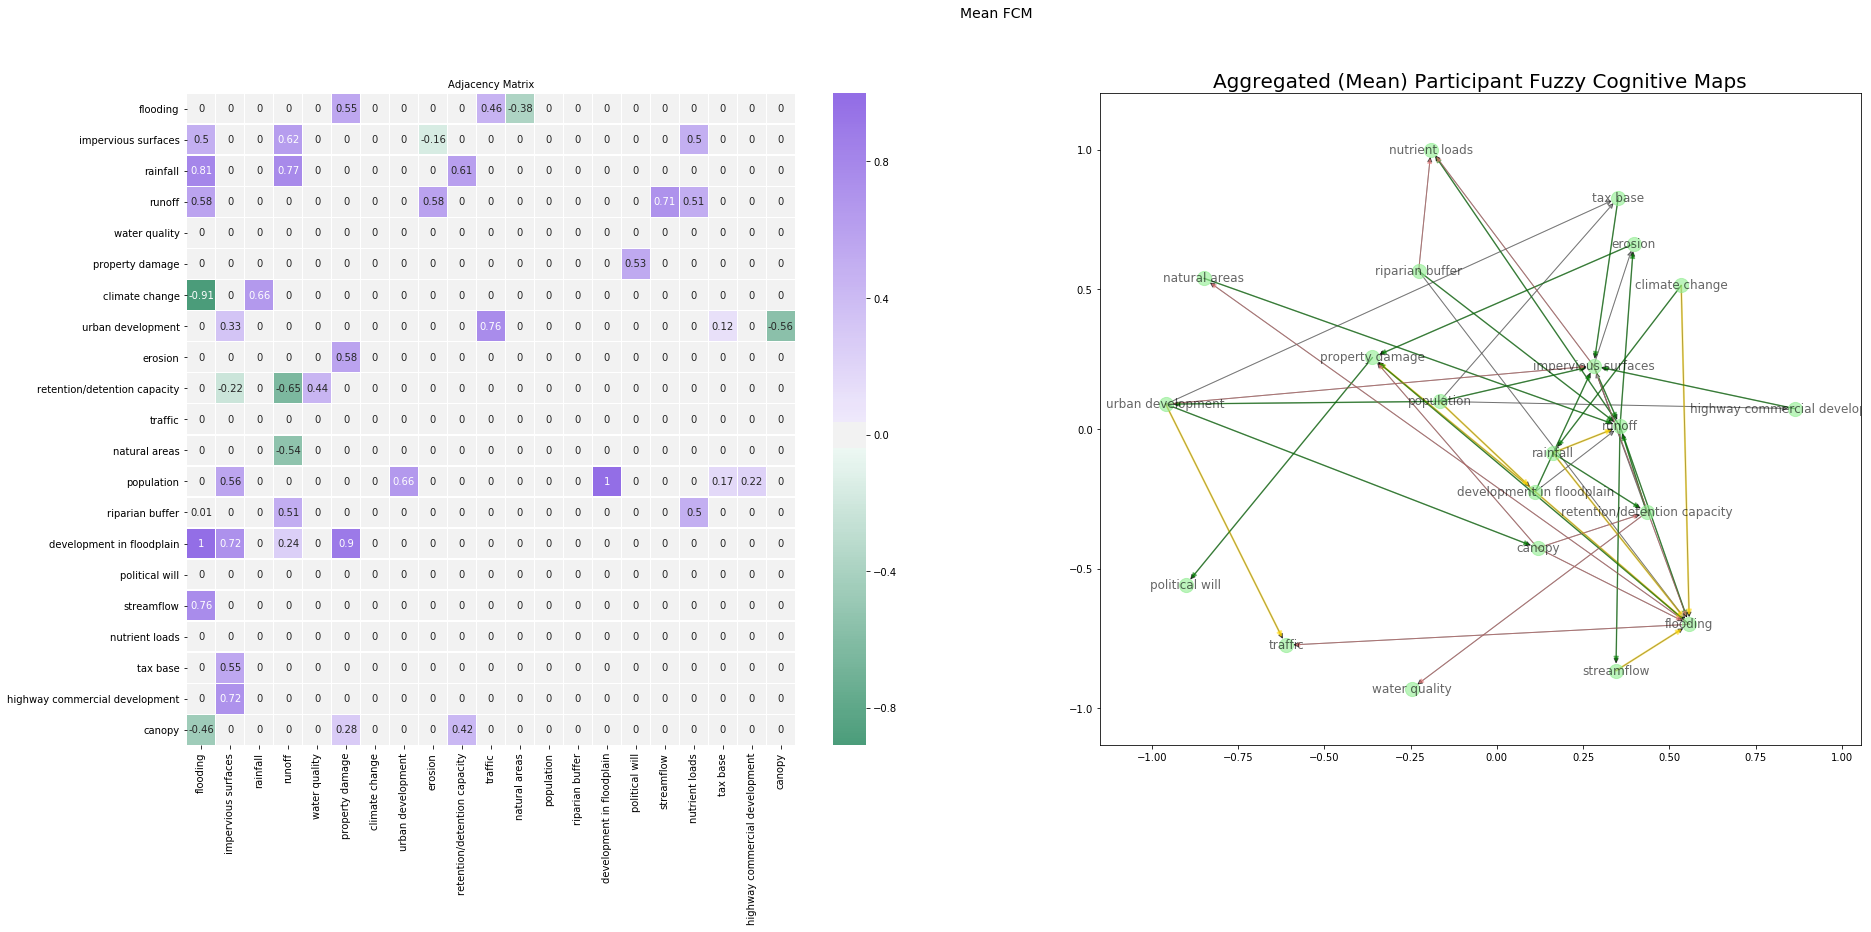

In [20]:
Adj_aggregated_FCM = aggregate_mean(All_ADJs, filtered_concepts)

df_agg_mean = pd.DataFrame(Adj_aggregated_FCM, index=filtered_concepts, columns=filtered_concepts)
fig, (ax, ax1) = plt.subplots(1,2,figsize=(30,12))
plt.suptitle('Mean FCM', fontsize=14)
ax.set_title("Adjacency Matrix", fontsize=10)

sns.heatmap(df_agg_mean.fillna(0), annot=True, linewidths=.5, ax=ax, center=0,cmap=cmap)
ax1.set_title("Aggregated (Mean) Participant Fuzzy Cognitive Maps", fontsize=20)

generate_map(Adj_aggregated_FCM, filtered_concepts,ax1)

## Mean of all FCMs (Include edges with weight equalling zero)

                                centrality
runoff                            0.801429
flooding                          0.759524
rainfall                          0.649524
impervious surfaces               0.630000
property damage                   0.266190
development in floodplain         0.218095
population                        0.150952
urban development                 0.141429
erosion                           0.103333
traffic                           0.101429
highway commercial development    0.078571
nutrient loads                    0.071905
streamflow                        0.070000
climate change                    0.051429
riparian buffer                   0.049048
tax base                          0.040000
political will                    0.025238
water quality                     0.020952
canopy                           -0.015238
retention/detention capacity     -0.032857
natural areas                    -0.043810


{'ordinary': 14,
 'receivers': 4,
 'transmitters': 3,
 'total variables': 21,
 'density': 0.10476190476190476,
 'complexity': 1.3333333333333333,
 'hierarchy': 0.8863636363636364}

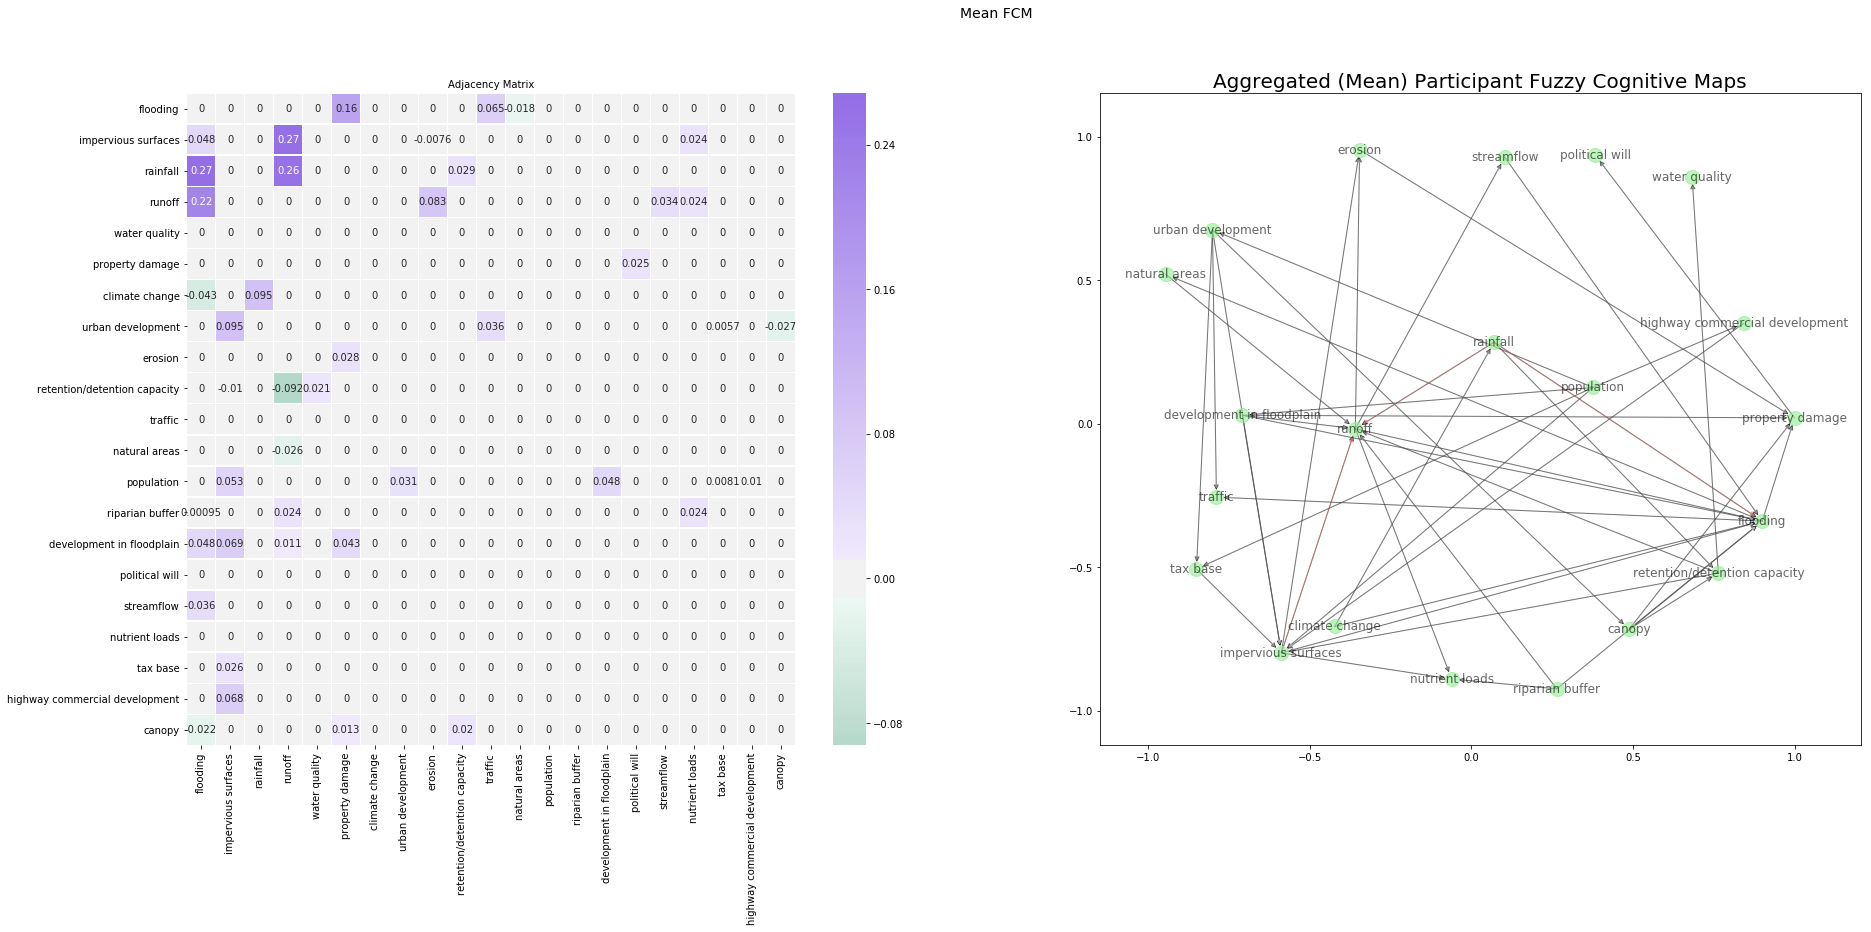

In [21]:
Adj_aggregated_FCM = aggregate_mean(All_ADJs, filtered_concepts, True)

df_agg_mean = pd.DataFrame(Adj_aggregated_FCM, index=filtered_concepts, columns=filtered_concepts)
fig, (ax, ax1) = plt.subplots(1,2,figsize=(30,12))
plt.suptitle('Mean FCM', fontsize=14)
ax.set_title("Adjacency Matrix", fontsize=10)

sns.heatmap(df_agg_mean.fillna(0), annot=True, linewidths=.5, ax=ax, center=0,cmap=cmap)
ax1.set_title("Aggregated (Mean) Participant Fuzzy Cognitive Maps", fontsize=20)

generate_map(Adj_aggregated_FCM, filtered_concepts,ax1)

### FCM Concepts -> Geospatial Simulation/Model 

> Send back to stakeholders for other modeling suggestions

- Water Quality: Kims project?
- Urban Development: FUTURES
- Natural Areas: FUTURES
- Rainfall: 
- Runoff: SIMWE
- Erosion: SIMWE
- Population: FUTURES 
- Flooding: HAND
- Impervious Surfaces: FUTURES
- Property Damage:
- Retention/Detention Capacity:
- Climate Change:
- Traffic (Transportation):

### References

Özesmi, U., & Özesmi, S. L. (2004). Ecological models based on people’s knowledge: a multi-step fuzzy cognitive mapping approach. Ecological Modelling, 176(1), 43–64. https://doi.org/10.1016/j.ecolmodel.2003.10.027
